In [3]:
library(abind)
library(magrittr)
library(tidyr)

library(ggplot2)
library(cowplot)
theme_set(theme_bw())

# library(scran)
# library(sva)
# library(Harman)


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [4]:
options(repr.plot.width = 6, repr.plot.height = 4)

In [5]:
# source files
src_files <- list.files('../../R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}

Sourced file: ../../R/calc.R
Sourced file: ../../R/misc.R
Sourced file: ../../R/normalise.R
Sourced file: ../../R/plot.R
Sourced file: ../../R/predict.R
Sourced file: ../../R/subset.R
Sourced file: ../../R/utils.R


## Import data

In [6]:
file_maqc <- "../../../diff_expr/data/MAQC-I/processed/mas5_original-ref.tsv"
raw_maqc <- read.table(file_maqc, sep = "\t", header = T, row.names = 1)

# MAQC metadata
# Class A - Universal Human Reference RNA (UHRR)
# Class B - Human Brain Reference RNA (HBRR)
batch_info <- as.factor(rep(1:6, each = 10))
class_info <- rep(rep(LETTERS[1:2], each = 5), 6)
metadata <- data.frame(batch_info, class_info, row.names = colnames(raw_maqc))

# SCALE->REMOVE->FILTER->LOG
scaled_maqc <- raw_maqc %>%
  normaliseMeanScaling()

log_maqc <- scaled_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

AFX_1_A1 AFX_1_A2 AFX_1_A3 AFX_1_A4 AFX_1_A5 AFX_1_B1 
6.167267 4.921776 6.064782 5.998307 5.594024 6.396092 
[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


In [7]:
log_nozero <- log_maqc[rowSums(log_maqc == 0) == 0, ]

## Affy probesets

In [187]:
is_affy <- startsWith(rownames(raw_maqc), 'AFFX')
log_affy <- log2_transform(raw_maqc[is_affy, ])

# pdf('~/Dropbox/tmp/sum-lg_affy.pdf', width = 4, height = 4)
# hist(rowSums(log_affy), breaks = 20)
# dev.off()

# selecting affy probesets with high expression (positive controls)
idx_affy <- rownames(log_affy)[rowSums(log_affy) > 200]
raw_affy <- raw_maqc[idx_affy, ]
raw_notaffy <- raw_maqc[!is_affy, ]

#### Raw

In [164]:
print(identical(rownames(metadata), colnames(raw_affy)))
trim <- 0.25
raw_stats <- data.frame(
  metadata,
  tm = sapply(raw_maqc, mean, trim = trim),
  sum_affy = colSums(raw_affy),
  sum_notaffy = colSums(raw_notaffy),
  pct_zero_affy = colSums(raw_affy == 0) / nrow(raw_affy), 
  pct_zero_notaffy = colSums(raw_notaffy == 0) / nrow(raw_notaffy),
  tm_affy = sapply(raw_affy, mean, trim = trim),
  tm_notaffy = sapply(raw_notaffy, mean, trim = trim),
  avg_nonzero_affy = colSums(raw_affy) / colSums(raw_affy != 0),
  avg_nonzero_notaffy = colSums(raw_notaffy) / colSums(raw_notaffy != 0)
)
raw_stats["proportion_affy"] <- raw_stats$tm_affy / raw_stats$tm

[1] TRUE


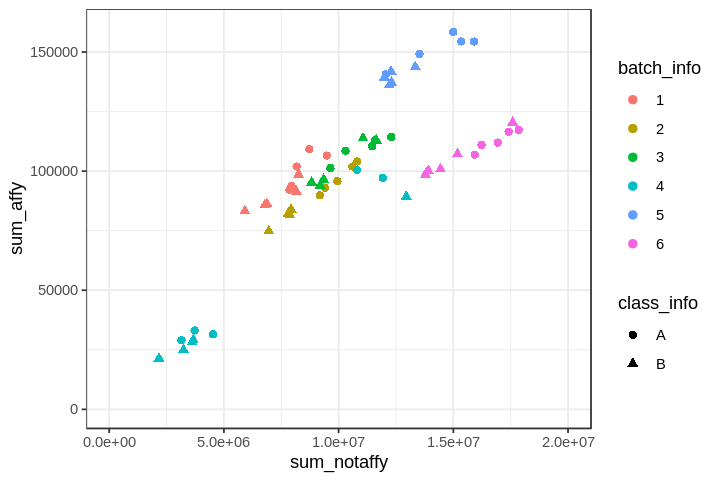

In [219]:
# mean v.s. pct_zero
# upper <- 2100
ax <- ggplot(raw_stats) +
  geom_point(
    aes(
      x = sum_notaffy, y = sum_affy,
      col = batch_info, shape = class_info
    ),
    cex = 2
  ) +
  xlim(0, 2e7) + ylim(0, 1.6e5)
ax

ggsave(
  '~/Dropbox/tmp/maqc_vs_raw-sum.pdf',
   ax, width = 5, height = 4
)

In [208]:
title <- sprintf("Trim = %.2f", trim)
ax1 <- ggplot(raw_stats) +
  geom_point(
    aes(
      x = batch_info, y = proportion_affy,
      col = batch_info, shape = class_info
    ),
    cex = 2.5, alpha = 0.8, show.legend = FALSE,
    position = position_jitterdodge(jitter.width = 2)
  ) + 
  labs(title = title) +
  ylim(0, 30)

ax2 <- ggplot(raw_stats) +
  geom_point(
    aes(
      x = class_info, y = proportion_affy,
      col = class_info
    ),
    cex = 3, show.legend = FALSE, 
    position = position_jitterdodge(jitter.width = 1)
  )
ax <- plot_grid(ax1, ax2)

# file <- sprintf('~/Dropbox/tmp/gif/prop_affy/maqc_prop_affy-%02d.png', trim * 100)
# ggsave(file, ax1, width = 6, height = 4)

#### Trimmed mean scaling

In [483]:
tms_affy <- scaled_maqc[idx_affy, ]
tms_notaffy <- scaled_maqc[!is_affy, ]

In [495]:
colmean_maqc <- colMeans(raw_maqc)
ms_maqc <- sweep(raw_maqc, 2, colmean_maqc, `*`)
ms_affy <- ms_maqc[idx_affy, ]
ms_notaffy <- ms_maqc[!is_affy, ]

In [677]:
print(identical(rownames(metadata), colnames(tms_affy)))
trim <- .02
tms_stats <- data.frame(
  metadata,
  tm = apply(scaled_maqc, 2, mean, trim = trim),
  sum_affy = colSums(tms_affy),
  sum_notaffy = colSums(tms_notaffy),
  pct_zero_affy = colSums(tms_affy == 0) / nrow(tms_affy), 
  pct_zero_notaffy = colSums(tms_notaffy == 0) / nrow(tms_notaffy),
  tm_affy = sapply(tms_affy, mean, trim = trim),
  tm_notaffy = sapply(tms_notaffy, mean, trim = trim),
  avg_nonzero_affy = colSums(tms_affy) / colSums(tms_affy != 0),
  avg_nonzero_notaffy = colSums(tms_notaffy) / colSums(tms_notaffy != 0)
)

[1] TRUE


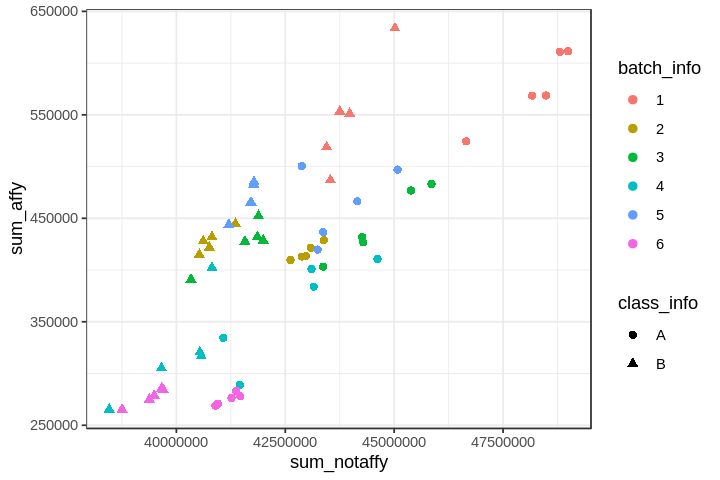

In [678]:
# mean v.s. pct_zero
# upper <- 2100
ax <- ggplot(tms_stats) +
  geom_point(
    aes(
      x = sum_notaffy, y = sum_affy,
      col = batch_info, shape = class_info
    ),
    cex = 2
  )
ax

# ggsave(
#   '~/Dropbox/tmp/maqc_vs_raw-sum.pdf',
#    ax, width = 5, height = 4
# )

In [684]:
ax1 <- ggplot(tms_stats) +
  geom_point(
    aes(
      x = batch_info, y = tm_notaffy,
      col = batch_info, shape = class_info
    ),
    cex = 2.5, alpha = 0.8, show.legend = FALSE,
    position = position_jitterdodge(jitter.width = 2)
  )

ax2 <- ggplot(tms_stats) +
  geom_point(
    aes(
      x = batch_info, y = tm_affy,
      col = batch_info, pch = class_info
    ),
    cex = 3, show.legend = FALSE, 
    position = position_jitterdodge(jitter.width = 1)
  )
ax <- plot_grid(ax1, ax2)

file <- sprintf('~/Dropbox/tmp/maqc_tms-tm.pdf')
ggsave(file, ax, width = 8, height = 4)

### Batch effect parameter: Beta
- Any value in using a multiplicative model to correct for batch effects? Might have
- Combat has issues with the overall mean impacted by batch class imbalances

In [8]:
fltr_maqc <- scaled_maqc %>%
  filterProbesets(0.7)

[1] "No. of probesets removed = 31192"


In [37]:
# obtain beta matrix for each batch i by g
# quality check on matrix to make sure var is tight
# obtain beta vector

#' Prepends if string values start with 0-9
prepend_ifnumeric <- function(x, prefix) {
  x <- as.character(x)
  has_numeric_prefix <- grepl("[0-9]", x)
  x[has_numeric_prefix] <- paste0(prefix, x[has_numeric_prefix])
  x
}

# TODO: compute beta: using median vs all samples
#' Compute batch scaling factor for each feature
#' If batch scaling factors are unable to be computed due to missing values,
#' NA will be assigned as the value of beta 
compute_beta <- function(
  X, metadata,
  beta.var.threshold = 0.05,
  dist.threshold = 1.7
) {
  # probeset i, sample j, batch k, class g
  #' If vector has less than 3 non-zero values: return NA
  #' Median of vector with all zero values results in NA
  median_nonzero <- function(x, ...) {
    if (length(x[x != 0]) < 3) {
      cnt <<- cnt + 1
      return(NA)
    }
    median(x[x != 0], ...)
  }
  mean_nonzero <- function(x, ...) {
    if (length(x[x != 0]) < 3) {
      cnt <<- cnt + 1
      return(NA)
    }
    mean(x[x != 0], ...)
  }

  cnt <- 0
  metadata <- metadata[colnames(X), , drop = FALSE] # metadata only of samples in X
  sample_classes <- prepend_ifnumeric(metadata$class_info, "C")
  sample_batches <- prepend_ifnumeric(metadata$batch_info, "B")
  n_classes <- length(unique(sample_classes))
  n_batches <- length(unique(sample_batches))
  # initialise arrays
  beta <- mu <- array(
    NA, dim = c(nrow(X), n_batches, n_classes),
    dimnames = list(rownames(X), unique(sample_batches), unique(sample_classes))
  )
  ref_mu <- array(
    NA, dim = c(nrow(X), n_classes),
    dimnames = list(rownames(X), unique(sample_classes))
  )
  X_classes <- split.default(X, sample_classes)

  for (g in names(X_classes)) {
    X_g <- X_classes[[g]]
    batch_g <- prepend_ifnumeric(metadata[colnames(X_g), "batch_info"], "B")
    X_batches <- split.default(X_g, batch_g)
    mu_g <- sapply(X_batches, apply, 1, mean_nonzero, na.rm = TRUE)
    ref_mu_g <- apply(mu_g, 1, median_nonzero, na.rm = TRUE)
    if (any(is.na(ref_mu_g)))
      warning(sprintf(
        "Class %s: %d out of %d features have median of batch medians with value zero.",
        as.character(g), sum(is.na(ref_mu_g)), nrow(X)
      ))
    beta_g <- data.frame(mu_g / ref_mu_g)
    for (k in colnames(mu_g)) {
      mu[, k, g] <- mu_g[, k]
      beta[, k, g] <- beta_g[, k]
    }
    ref_mu[, g] <- ref_mu_g
  }
  
  ## Estimating outlier gamma
  # Compute class pair ratios
  n_pairs <- 1
  # Assume: 2 classes have been chosen for beta
  pair_classes <- c("A", "B")
  rho <- mu[, , pair_classes[1]] / mu[, , pair_classes[2]]
  rho_mu <- apply(rho, 1, median_nonzero)
  cat(sprintf("No. of features with missing rho means = %d\n", sum(is.na(rho_mu))))
  rho_sigma <- apply(rho, 1, sd, na.rm = TRUE)
  # 1: estimate gamma from rho
  gamma_1 <- rho / rho_mu
  # TODO: beware of all rhos for genes is NA
  # Identifying outlier (batch, class, feature) that requires gamma correction
  # Identification using gamma_1 only
  outlier_indices <- which(
    (gamma_1 > dist.threshold | gamma_1 < (1 / dist.threshold)) & gamma_1 != 0,
    arr.ind = TRUE
  ) # gamma_1 cannot be zero or NA
  beta_1 <- beta[, , pair_classes[1]]
  beta_2 <- beta[, , pair_classes[2]]
  outlier_beta <- cbind(beta_1[outlier_indices], beta_2[outlier_indices])
  # class with beta closer to 1 is reference class
  outlier_class <- apply(abs(log(outlier_beta)), 1, which.max)
  # 2: estimate gamma from beta
  outlier <- cbind(
    outlier_indices,
    rho = rho[outlier_indices],
    beta_1 = beta_1[outlier_indices],
    beta_2 = beta_2[outlier_indices],
    gamma_1 = gamma_1[outlier_indices],
    gamma_2 = beta_1[outlier_indices] / beta_2[outlier_indices],
    outlier_class = outlier_class
  )
  # use gamma_1 as gamma_2 may be biased by possible errors in estimating ref in classes
  
  # Correction using gamma_1
  # (batch, outlier_class) combinations
  combinations <- split.data.frame(
    outlier, list(outlier[, "col"], outlier[, "outlier_class"])
  )
  cat(sprintf("No. of gamma outliers = %d\n", nrow(outlier)))
  for (outlier_kg in combinations) {
    if (dim(outlier_kg)[1] == 0) next
    k <- unique(sample_batches)[outlier_kg[1, "col"]]
    class_idx <- outlier_kg[1, "outlier_class"]
    g <- pair_classes[class_idx]
    # subset target patients
    sids <- colnames(X)[sample_batches == k & sample_classes == g]
    gamma_kg <- outlier_kg[, "gamma_1"]
    stopifnot(length(gamma_kg) == length(rownames(outlier_kg)))
    if (class_idx == 2) {
      # if outlier_class == 2 -> multiply by gamma_1
      X[rownames(outlier_kg), sids] <- X[rownames(outlier_kg), sids] * gamma_kg
    } else if (class_idx == 1) {
      # if outlier_class == 1 -> divide by gamma_1
      # gamma defined as "1"/"2"
      X[rownames(outlier_kg), sids] <- X[rownames(outlier_kg), sids] / gamma_kg
    } else {
      warning("Gamma was not corrected!")
    }
  }
  # TODO: Do we update mu to recalculate some betas, and then identify betas to correct?
  # TODO: Can directly scale mus
  
  cat(sprintf(
    "Median was computed for %d non-zero vectors with length < 3.\n", cnt
  ))
  # beta_arr <- abind::abind(list_betas, rev.along = 0) # beta for all classes
  beta_hat <- apply(beta, c(1, 2), mean, na.rm = FALSE) #
  beta_hat[is.nan(beta_hat)] <- NA # mean of vector with all NA values returns NaN
  cat(sprintf(
    "No. of NAs in beta_hat: %d/%d\n",
    sum(is.na(beta_hat)), length(beta_hat)
  ))
  beta_hat[is.na(beta_hat)] <- 1 # replace NA with 1 (i.e. do not correct if beta = NA)
  beta_sigma2 <- apply(beta, c(1, 2), var, na.rm = FALSE)
  
#   # Correction using beta_hat
#   X_batches <- split.default(X, batch)
#   if (sum(is.na(beta_hat)) > 0 | sum(beta_hat == 0, na.rm = TRUE) > 0)
#     stop("Beta_hat matrix contains zeros or NAs.")
#   for (k in colnames(beta_hat)) {
#     X_batches[[k]] <- X_batches[[k]] / beta_hat[, k]
#   }
#   X1 <- do.call(cbind, unname(X_batches))
#   X1 <- X1[, colnames(X)]
  
  list(
    X = X,
    beta = beta,
    beta_mu = beta_hat, # mean of beta
    beta_sigma2 = beta_sigma2,
    mu = mu, # mean of each (batch, class)
    ref_mu = ref_mu,
    rho = rho,
    gamma_1 = gamma_1,
    outlier = outlier
  )
}

In [ ]:
# Changes
# Determination of outlier class
# Using mean nonzero for calc of mu

In [38]:
# TODO: Is multiplication correct? Divison is ok, but multiplication introduces variance. How to collect stats on this?
# TODO: Problems with median?

In [39]:
obj <- compute_beta(fltr_maqc, metadata, dist.threshold = 2)

No. of features with missing rho means = 4345
No. of gamma outliers = 202
Median was computed for 7722 non-zero vectors with length < 3.
No. of NAs in beta_hat: 6983/140898


In [40]:
X_corrected <- obj$X
beta <- obj$beta
beta_mu <- obj$beta_mu
beta_sigma2 <- obj$beta_var
mu <- obj$mu
ref_mu <- obj$ref_mu
rho <- obj$rho
outlier <- obj$outlier

In [91]:
ps <- rownames(outlier)[15]
# examine outlier
print(outlier[ps, , drop = F])
print(beta[ps, ,])

             row col       rho   beta_1    beta_2 gamma_1  gamma_2
1554476_x_at 363   2 0.1985867 1.325755 0.2261081 5.80698 5.863369
             outlier_class
1554476_x_at             2
           A         B
B1 1.1295352 1.9205703
B2 1.3257551 0.2261081
B3 1.0310122 0.9160946
B4 0.8246752 1.7281822
B5 0.9689878 1.0839054
B6 0.6125098 0.0433157


In [92]:
# Determination based on actual dist and not multiplication factor
# just implement beta correction to see how

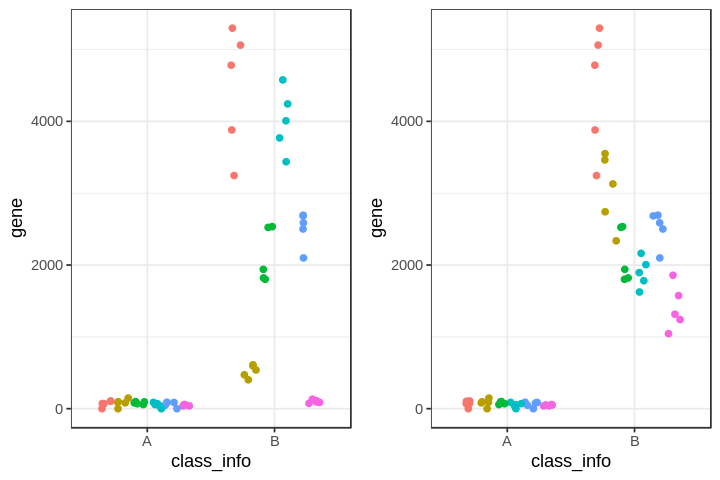

In [93]:
X1 <- merge(t(fltr_maqc[ps,]), metadata, by = "row.names")
colnames(X1)[2] <- "gene"
X2 <- merge(t(X_corrected[ps,]), metadata, by = "row.names")
colnames(X2)[2] <- "gene"

ax1 <- ggplot(X1, aes(x = class_info, y = gene, color = batch_info)) +
  geom_point(position = position_jitterdodge(), show.legend = F)
ax2 <- ggplot(X2, aes(x = class_info, y = gene, color = batch_info)) +
  geom_point(position = position_jitterdodge(), show.legend = F)
plot_grid(ax1, ax2)

In [1938]:
idx <- which(rho_dist > 2, arr.ind = TRUE)
head(idx)

,row,col
1552474_a_at,45,1
1552485_at,47,1
1552717_s_at,84,1
1553111_a_at,125,1
1553538_s_at,175,1
1554077_a_at,262,1


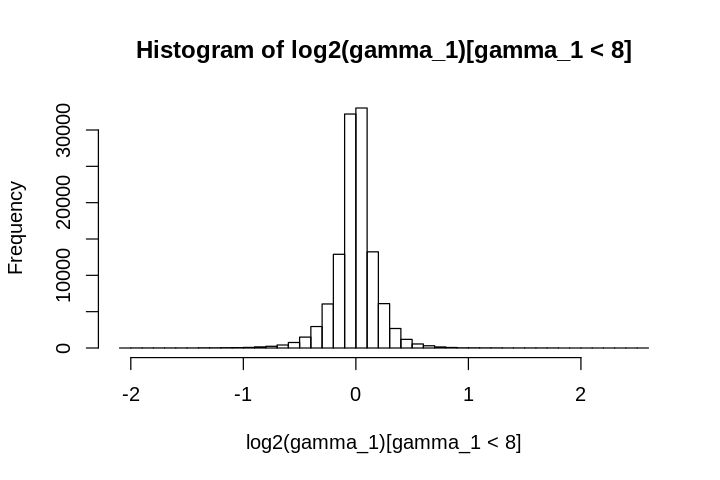

In [1869]:
hist(log2(gamma_1)[gamma_1 < 8], breaks = 50)

In [1389]:
# TODO: Analysis of variance
summary.beta <- function(obj, beta.var.threshold = 0.05) {
  beta <- obj$beta
  beta_mu <- obj$beta_mu
  beta_var <- obj$var
  mu <- obj$mu
  ref_mu <- obj$ref_mu
  
  cat(sprintf(
    "No.  of betas with var < threshold: %d/%d\n",
    sum(beta_var < beta.var.threshold, na.rm = TRUE), length(beta_var)
  ))
  print("sorted var:")
  print(head(sort(var, decreasing=T), 50))
  # variance will be na if only one number is present
  print("no. of na values in var:")
  print(sum(is.na(var)))
}

In [1562]:
summary.beta(obj)

[1] "sorted var:"
 [1] 4.9891202 2.2667947 1.6420046 1.3932471 1.0825067 0.9999653 0.9798327
 [8] 0.9772729 0.9647424 0.9092458 0.8467257 0.8088559 0.8074721 0.7638124
[15] 0.7191600 0.6515824 0.6361205 0.6302794 0.6116065 0.5783368 0.5642799
[22] 0.5555648 0.5526619 0.5428023 0.5393791 0.5328701 0.5325231 0.5200437
[29] 0.5193018 0.5080120 0.5074667 0.5060426 0.5007551 0.5004416 0.4945989
[36] 0.4856211 0.4808999 0.4730222 0.4720559 0.4680284 0.4576181 0.4532858
[43] 0.4515198 0.4512833 0.4497646 0.4474288 0.4457740 0.4415183 0.4414713
[50] 0.4364419
[1] "no. of na values in var:"
[1] 6983


In [1637]:
idx <- which(sigma2 > .5, arr.ind = T)
idx2 <- which(sigma2 < .1, arr.ind = T)

In [1592]:
i <- 6
print(idx[i, , drop = F])
ps <- rownames(idx)[i]
print(beta[ps, ,])
print(mu[ps, ,])
print(ref_mu[ps, ]) # SOMETHING WRONG

            row col
1569024_at 1551   2
           A         B
B1 1.0219467        NA
B2 1.2597195 2.2917303
B3 0.9164842 1.0552274
B4 1.0982200        NA
B5 0.9083908 0.9447726
B6 0.9780533 0.8759700
          A         B
B1 76.60118        NA
B2 94.42371 115.14975
B3 68.69612  53.02071
B4 82.31833        NA
B5 68.08947  47.47082
B6 73.31110  44.01378
       A        B 
74.95614 50.24577 


In [1618]:
ps <- "1553185_at"
print(beta[ps, ,])
print(mu[ps, ,])
print(ref_mu[ps, ]) # SOMETHING WRONG

            A          B
B1 1.32131885 1.12113164
B2 0.85139672 1.00237528
B3 0.98636069 0.84665771
B4 1.15949345 1.11293562
B5 1.01363931 0.99762472
B6 0.09756173 0.03406237
           A         B
B1 6964.6175 6101.0835
B2 4487.6772 5454.8236
B3 5199.0668 4607.4245
B4 6111.6425 6056.4817
B5 5342.8513 5428.9716
B6  514.2439  185.3639
       A        B 
5270.959 5441.898 


In [1572]:
# i <- 7
# print(idx2[i, , drop = F])
# ps <- rownames(idx2)[i]
# print(beta[ps, ,])
# print(mu[ps, ,])
# print(ref_mu[ps, ]) # SOMETHING WRONG

#### Investigation
- 223578_x_at (DE): Good (All values in batch are multiplied by a class-specific factor, other batches no)
- 223607_x_a: Non-zero median is an outlier (Bayesian)
- 224559_at: Miscalibrated ref_mu
- 201222_s_at: Class-specific batch effect for one

#### Ideas
- Bias to inaction: If NA do not correct
- Compare variance of batch medians between batches
    - Does each batch have a different max value? Borrowing information across genes

- calculate class ratios -> to correct: closer to 1 is base.
- Factor closer to one is the reference, the other is the outlier factor
- detect when need gamma outlier correction
    1. gamma_1 > 1.5
    2. gamma_2 > 1.5?
    3. rho = 1?
- detect when need beta correction
    - if beta var is low & >1 beta is present & change is significant enough?
    - correct using beta closer to 1
    - what if only beta for one class is present
    - should not use beta mean to determine change as that would include outlier

- if need gamma correction then look to see whether it needs beta correction?
    - Perform gamma correction first. Then after that check to perform beta.

In [ ]:
# Decide when to allow for extra factor, when not to.
# When to calculate mean, and when to allow for class-specific in that batch and feature

In [1296]:
# Sophisticated way to calculate mu
# Try to optimize ref_mu to match class A and class B betas after discarding outliers
# Assuming there is a class-specific outlier scaling factor
# Bayesian to help missing values

## Evaluate: Batch effects

In [44]:
X_2 <- X_corrected %>%
  removeProbesets() %>%
  log2_transform()

[1] "No. of ambiguous and AFFY probesets removed: 9534"


In [45]:
# other batch correction methods

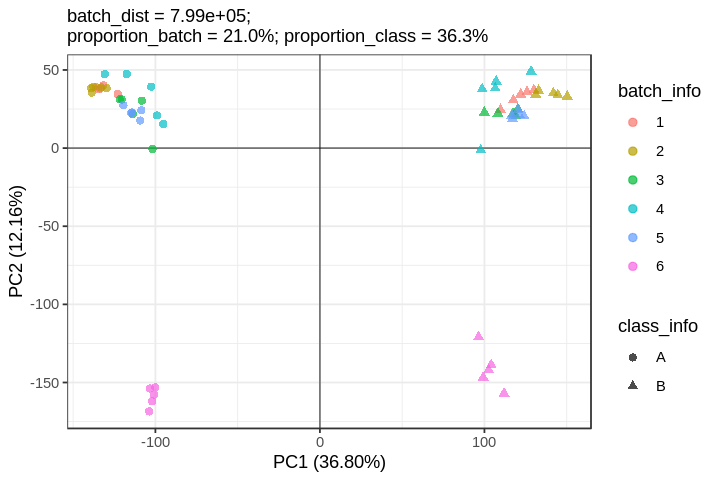

In [46]:
vars <- calc_var_prop(X_2, metadata)
dists <- calc_batch_dist(X_2, metadata)
ax <- ggplot_pca(
  X_2, metadata,
  col = 'batch_info', pch = 'class_info'
)
ax <- ax +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax

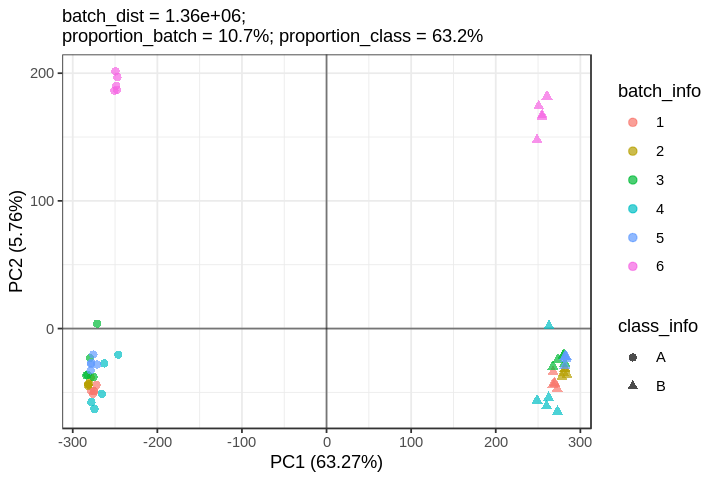

In [19]:
vars <- calc_var_prop(log_maqc, metadata)
dists <- calc_batch_dist(log_maqc, metadata)
ax <- ggplot_pca(
  log_maqc, metadata,
  col = 'batch_info', pch = 'class_info'
)
ax <- ax +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax

## Plot: Beta

In [664]:
# Plot of beta
b_affy <- subset_cols(tms_affy, metadata, class_info == 'B')
b_notaffy <- subset_cols(tms_notaffy, metadata, class_info == 'B') %>%
  filterProbesets(0.7)

[1] "No. of probesets removed = 29250"


In [697]:
head(b_notaffy)

,AFX_1_B1,AFX_1_B2,AFX_1_B3,AFX_1_B4,AFX_1_B5,AFX_2_B1,AFX_2_B2,AFX_2_B3,AFX_2_B4,AFX_2_B5,⋯,AFX_5_B1,AFX_5_B2,AFX_5_B3,AFX_5_B4,AFX_5_B5,AFX_6_B1,AFX_6_B2,AFX_6_B3,AFX_6_B4,AFX_6_B5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1007_s_at,2410.9255,2785.4583,2583.7065,2963.5712,2516.6884,3434.7262,3028.6368,3659.5464,3148.1692,3276.5248,⋯,3470.6552,3041.1627,3545.2712,3571.8986,3513.0743,2954.9841,3101.7145,3042.99599,3159.37986,2972.90782
1053_at,465.2302,339.7024,369.6202,422.7620,399.0965,373.6747,423.2653,480.8927,355.8614,464.5322,⋯,436.8047,372.0587,377.9832,402.7760,303.8839,337.3371,402.5660,411.27761,353.62413,433.13526
117_at,190.8493,166.5901,184.5802,128.2648,174.8916,267.6797,129.2181,200.6130,205.4121,206.0379,⋯,247.3613,156.1762,194.1627,182.9729,236.3074,139.8672,184.9695,118.26857,180.97175,151.59523
121_at,377.0159,408.5412,448.8254,516.9154,409.0834,648.9385,725.4264,752.5721,703.1514,663.7139,⋯,450.6679,432.5895,407.9335,474.4991,502.9323,388.3307,513.1567,371.91572,393.32482,454.66298
1294_at,183.1103,158.6291,267.8892,226.1541,177.9031,0.0000,281.5853,267.4362,279.2142,306.2277,⋯,0.0000,0.0000,209.7259,223.6610,170.4386,155.6090,132.0992,174.10677,224.86460,213.55540
1316_at,195.1177,151.1061,226.7714,128.7434,119.6109,492.5930,520.1550,426.4984,566.3086,484.8579,⋯,374.6801,274.5221,363.6244,255.2073,326.4926,106.4727,118.0693,69.57254,99.88923,54.20977


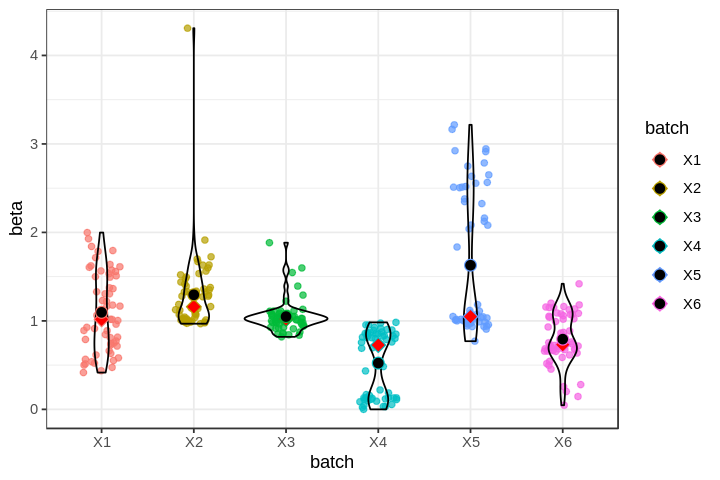

In [670]:
# boxplot
ax <- ggplot(
    long_beta,
    aes(x = batch, y = beta, color = batch)
  ) +
    geom_point(cex = 1.5, alpha = .7, position = position_jitter(width = .2)) +
    geom_violin(fill = NA, color = 'black') +
    stat_summary(fun.y = median, geom = "point", shape = 23, fill = "red", size = 3) +
    stat_summary(fun.y = mean, geom = "point", shape = 21, fill = "black", size = 3)
ax
ggsave("~/Dropbox/tmp/maqc_classb_affy-beta.pdf", ax, width = 8, height = 4)

#### Affy batch mean scaling

In [172]:
print(identical(rownames(metadata), colnames(raw_affy)))
affybms_stats <- data.frame(
  metadata,
  sum_affy = colSums(raw_affy),
  sum_notaffy = colSums(scaled_notaffy),
  pct_zero_affy = colSums(raw_affy == 0) / nrow(raw_affy), 
  pct_zero_notaffy = colSums(scaled_notaffy == 0) / nrow(scaled_notaffy),
  avg_nonzero_affy = colSums(raw_affy) / colSums(raw_affy != 0),
  avg_nonzero_notaffy = colSums(scaled_notaffy) / colSums(scaled_notaffy != 0)
)
affybms_stats["proportion_affy"] <- affybms_stats$sum_affy / 
  (affybms_stats$sum_affy + affybms_stats$sum_notaffy)

[1] TRUE


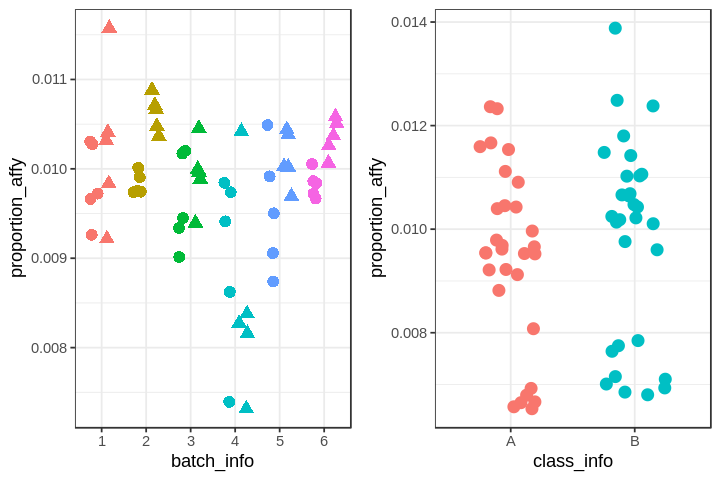

In [161]:
ax1 <- ggplot(scaled_affy_stats) +
  geom_point(
    aes(
      x = batch_info, y = proportion_affy,
      col = batch_info, shape = class_info
    ),
    cex = 3, show.legend = FALSE,
    position = position_jitterdodge(jitter.width = 1)
  )
ax2 <- ggplot(raw_stats) +
  geom_point(
    aes(
      x = class_info, y = proportion_affy,
      col = class_info
    ),
    cex = 3, show.legend = FALSE,
    position = position_jitterdodge(jitter.width = 1)
  )
ax <- plot_grid(ax1, ax2)
ax
# ggsave('~/Dropbox/tmp/maqc_proportion_affy-bs_affy.pdf', ax, width = 8, height = 4)

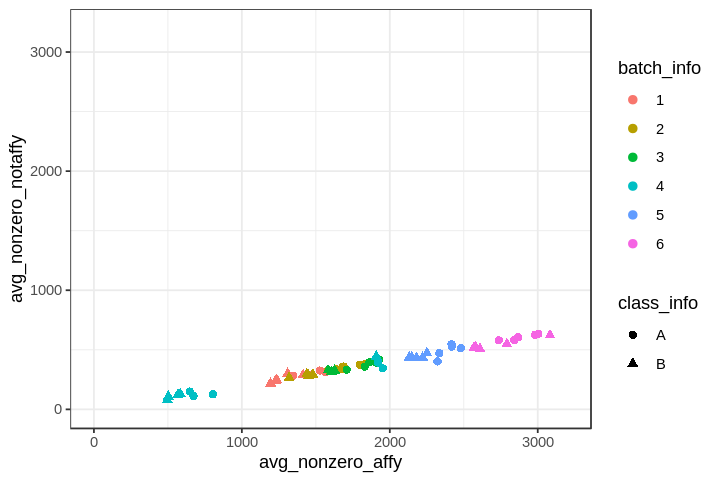

In [163]:
# ax <- ggplot(scaled_affy_stats) +
#   geom_point(
#     aes(
#       x = batch_info, y = avg_nonzero_affy,
#       col = batch_info, shape = class_info
#     ),
#     cex = 3,
#     position = position_jitterdodge(jitter.width = 3)
#   )

upper <- 3200
ax <- ggplot(scaled_affy_stats) +
  geom_point(
    aes(
      x = avg_nonzero_affy, y = avg_nonzero_notaffy,
      col = batch_info, shape = class_info
    ),
    cex = 2
  ) +
  xlim(0, upper) + ylim(0, upper)

ax

# ggsave(
#   '~/Dropbox/tmp/maqc_vs-batch_scaled_affy.pdf',
#    ax, width = 5, height = 4
# )

## Affy mean scaling

In [237]:
# divide by no. of non-zero values
tm_affy <- sapply(raw_affy, mean, trim = 0.02)
mean_nonzero_affy <- colSums(raw_affy) / colSums(raw_affy != 0)

affyms_factor <- 500 / tm_affy
affyms_maqc <- sweep(raw_maqc, 2, affyms_factor, `*`)

log_affyms_maqc <- affyms_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

log_affyms_nozero <- log_affyms_maqc[rowSums(log_affyms_maqc == 0) == 0, ]

[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


### Using imputed values

In [10]:
pairwise <- pairwise_lm(raw_maqc, metadata, idx_affy)
imputed <- impute.pairwise(pairwise, raw_maqc, idx_affy)

In [11]:
imputed_maqc <- imputed$X
imputed_affy <- imputed_maqc[idx_affy, ]

In [21]:
# divide by no. of non-zero values
avg_imputed_affy <- colSums(imputed_affy) / nrow(imputed_affy)
affyimp_factor <- 500 / avg_imputed_affy
affyimp_maqc <- sweep(raw_maqc, 2, affyimp_factor, `*`)

log_affyimp_maqc <- affyimp_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

log_affyimp_nozero <- log_affyimp_maqc[rowSums(log_affyimp_maqc == 0) == 0, ]

[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


In [ ]:
# assume that imputation is correct
# why does trimmed mean have such a drastic effect?
# trimmed mean does not have a drastic effect?
# why does tms have no batch effects but affyms has?

In [528]:
i <- 0

[1] "AFX_6_B5"


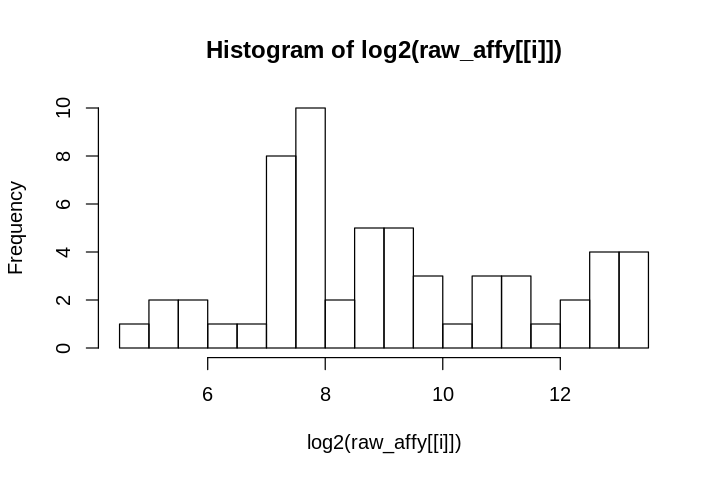

In [588]:
i <- i + 1
print(colnames(raw_affy)[i])
hist(log2(raw_affy[[i]]), breaks = 30)

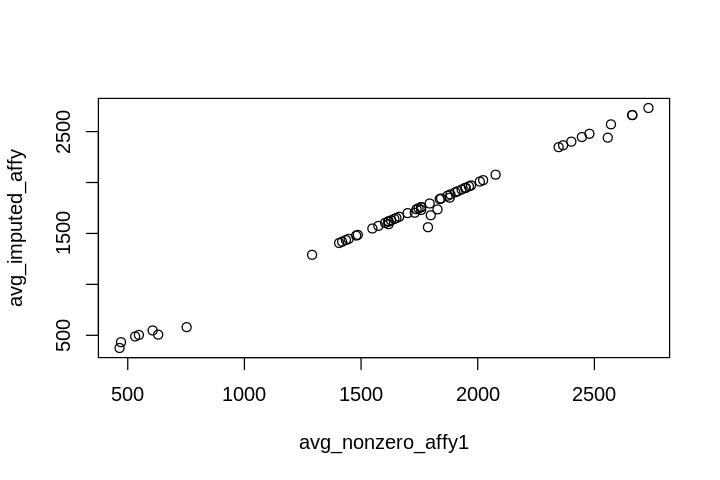

In [490]:
plot(avg_nonzero_affy1, avg_imputed_affy)

## Batch scaling
- Calculation of batch correction factor and multiplication of factor to non-affy features

In [289]:
bscaled_maqc <- scale_batch_affy(raw_maqc, metadata, idx_affy)

Class A (median slope = 0.073):
Scaled batch 1 with original slope of 0.055 to 0.073
Scaled batch 2 with original slope of 0.074 to 0.073
Scaled batch 3 with original slope of 0.071 to 0.073
Scaled batch 4 with original slope of 0.086 to 0.073
Scaled batch 5 with original slope of 0.067 to 0.073
Scaled batch 6 with original slope of 0.113 to 0.073

Class B (median slope = 0.074):
Scaled batch 1 with original slope of 0.059 to 0.074
Scaled batch 2 with original slope of 0.073 to 0.074
Scaled batch 3 with original slope of 0.074 to 0.074
Scaled batch 4 with original slope of 0.113 to 0.074
Scaled batch 5 with original slope of 0.066 to 0.074
Scaled batch 6 with original slope of 0.113 to 0.074



In [290]:
# divide by no. of non-zero values
tm_affy <- sapply(raw_affy, mean, trim = 0.02)
affyms_factor <- 500 / tm_affy
affybms_maqc <- sweep(bscaled_maqc, 2, affyms_factor, `*`)

log_affybms_maqc <- affybms_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()
log_affybms_nozero <- log_affybms_maqc[
  rowSums(log_affybms_maqc == 0) == 0, ]

[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


#### Investigate: Scale factors

In [226]:
trimmed_mean <- sapply(raw_maqc, mean, trim = 0.02)
tms_factor <- 500 / trimmed_mean

In [227]:
tms_sums <- colSums(scaled_maqc)
affybms_sums <- colSums(affybms_maqc)

In [150]:
scale_factors <- data.frame(
  metadata, tms_factor, affyms_factor, affybms_factor
)

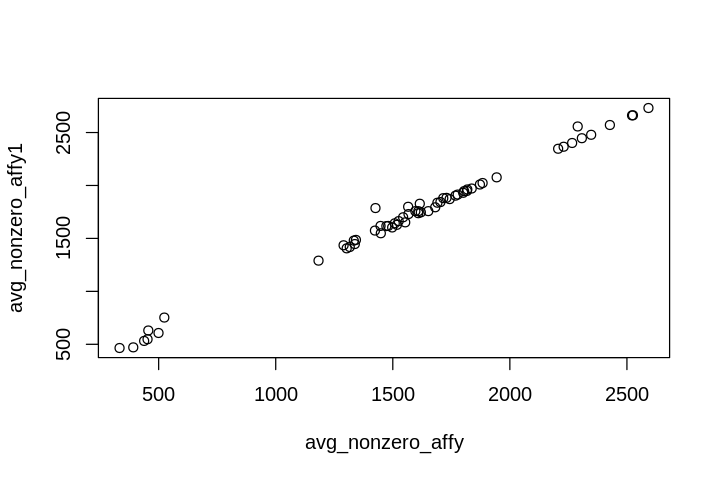

In [271]:
plot(avg_nonzero_affy, avg_nonzero_affy1)

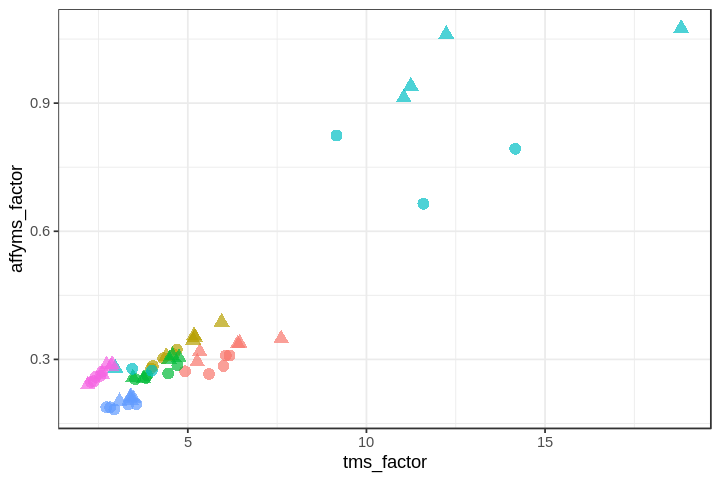

In [245]:
ax1 <- ggplot(scale_factors) +
  geom_point(
    aes(
      x = batch_info, y = tms_factor,
      col = batch_info, shape = class_info
    ), cex = 2,
    position = position_jitterdodge(),
    show.legend = FALSE
  )
ax2 <- ggplot(scale_factors) +
  geom_point(
    aes(
      x = batch_info, y = affybms_factor,
      col = batch_info, shape = class_info
    ), cex = 2,
    position = position_jitterdodge(), 
    show.legend = FALSE
  )
ax <- plot_grid(ax1, ax2, nrow = 2)

ax3 <- ggplot(scale_factors) +
  geom_point(
    aes(
      x = tms_factor, y = affyms_factor,
      col = batch_info, shape = class_info
    ), cex = 3, alpha = 0.7,
    show.legend = FALSE
  )
ax3
# ggsave('~/Dropbox/tmp/maqc_vs-affyms_tms.pdf',
#       ax3, width = 8, height = 8)

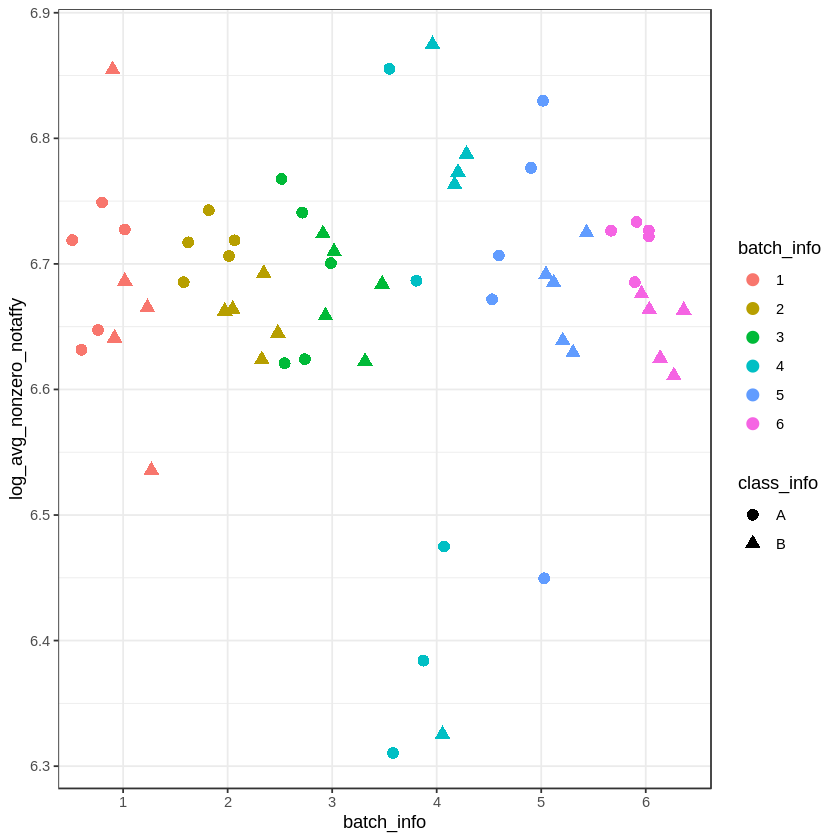

In [486]:
# print(identical(rownames(metadata), colnames(affyms_maqc)))
affyms_stats <- data.frame(
  metadata,
  log_avg_nonzero_notaffy = log2(colSums(affyms_maqc) / colSums(affyms_maqc != 0)),
  avg_nonzero_notaffy = colSums(log_affyms_maqc) / colSums(log_affyms_maqc != 0)
)
ax <- ggplot(affyms_stats) +
  geom_point(
    aes(
      x = batch_info, y = log_avg_nonzero_notaffy,
      col = batch_info, shape = class_info
    ),
    cex = 3,
    position = position_jitterdodge(jitter.width = 3)
  )
ax

# ggsave(
#   '~/Dropbox/tmp/maqc_avg_nonzero_notaffy-batch_affyms.pdf',
#    ax, width = 6, height = 4
# )

[1] TRUE


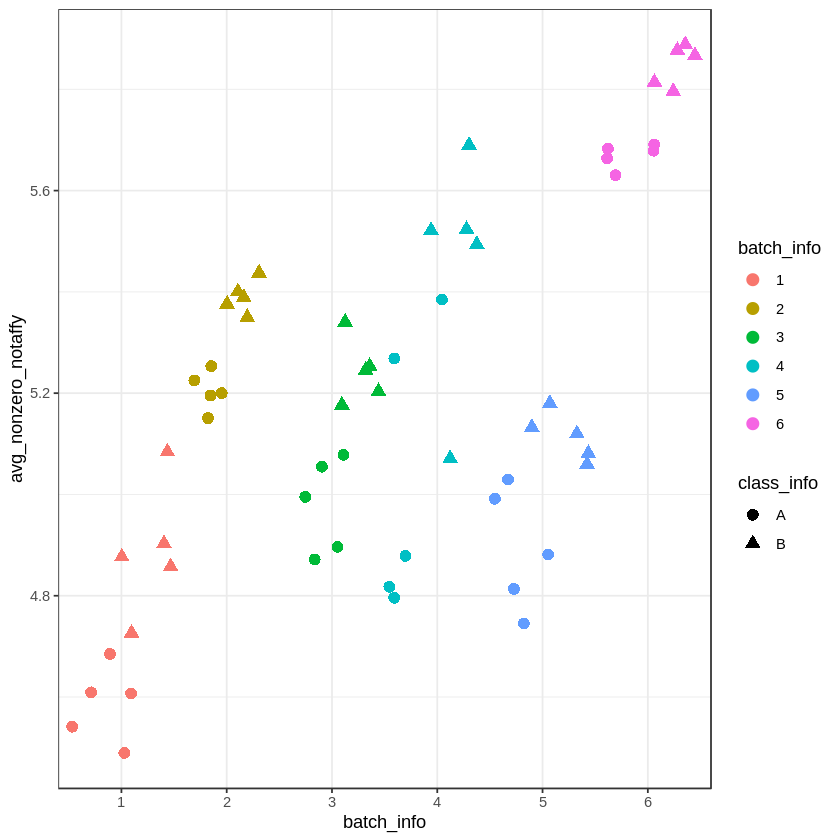

In [148]:
# print(identical(rownames(metadata), colnames(affyms_maqc)))
# affyms_stats <- data.frame(
#   metadata,
#   avg_nonzero_notaffy = colSums(log_affyms_maqc) / colSums(log_affyms_maqc != 0)
# )

# ax <- ggplot(affyms_stats) +
#   geom_point(
#     aes(
#       x = batch_info, y = avg_nonzero_notaffy,
#       col = batch_info, shape = class_info
#     ),
#     cex = 3,
#     position = position_jitterdodge(jitter.width = 3)
#   )
# ax

# ggsave(
#   '~/Dropbox/tmp/maqc_avg_nozero_notaffy-affyms.pdf',
#    ax, width = 6, height = 4
# )

## PCA

In [496]:
log_ms_maqc <- ms_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


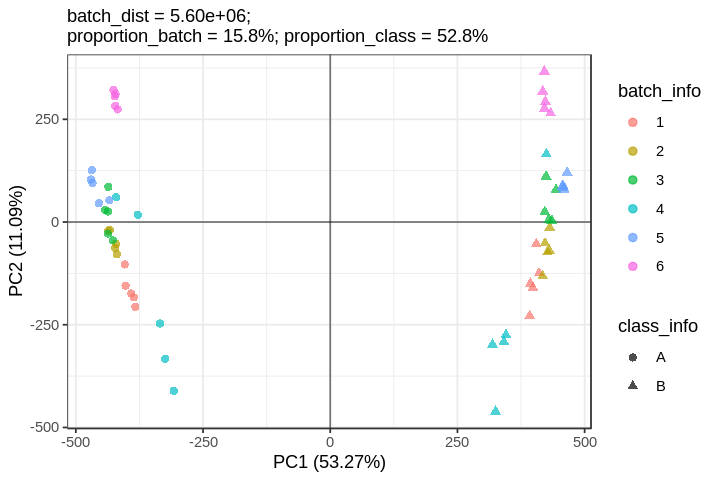

In [497]:
vars <- calc_var_prop(log_ms_maqc, metadata)
dists <- calc_batch_dist(log_ms_maqc, metadata)
ax <- ggplot_pca(
  log_ms_maqc, metadata,
  col = 'batch_info', pch = 'class_info'
)
ax <- ax +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax

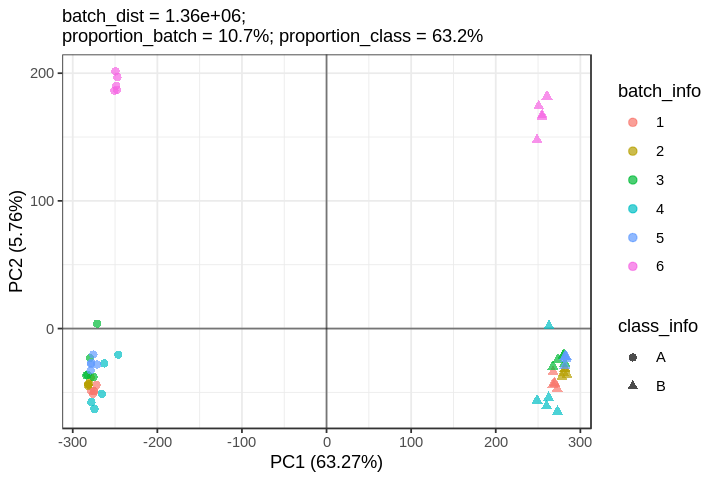

In [237]:
ax <- ggplot_pca(
  log_maqc, metadata,
  col = 'batch_info', pch = 'class_info'
)

vars <- calc_var_prop(log_maqc, metadata)
dists <- calc_batch_dist(log_maqc, metadata)
ax <- ax +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax
ggsave('~/Dropbox/tmp/maqc_pca-log_tms.pdf',
       ax, width = 6, height = 4)

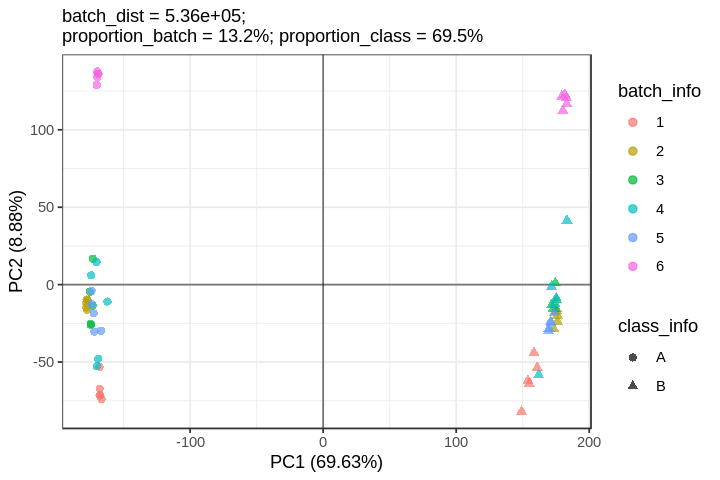

In [9]:
ax <- ggplot_pca(
  log_affyms_maqc, metadata,
  col = 'batch_info', pch = 'class_info'
)
vars <- calc_var_prop(log_affyms_maqc, metadata)
dists <- calc_batch_dist(log_affyms_maqc, metadata)
ax <- ax +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax
# ggsave('~/Dropbox/tmp/maqc_pca-log_affyms_trim.pdf',
#        ax, width = 6, height = 4)

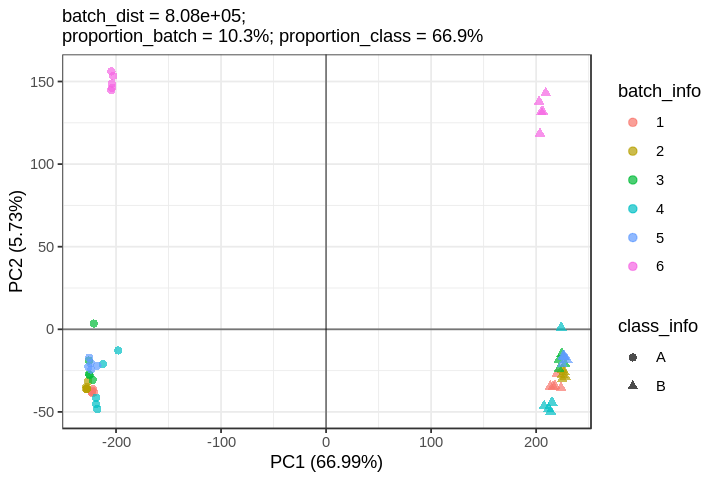

In [254]:
ax <- ggplot_pca(
  log_affybms_maqc, metadata,
  col = 'batch_info', pch = 'class_info'
)
vars <- calc_var_prop(log_affybms_maqc, metadata)
dists <- calc_batch_dist(log_affybms_maqc, metadata)
ax <- ax +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax
ggsave('~/Dropbox/tmp/maqc_pca-log_affybms_trim_matched.pdf',
       ax, width = 6, height = 4)

#### No zeros

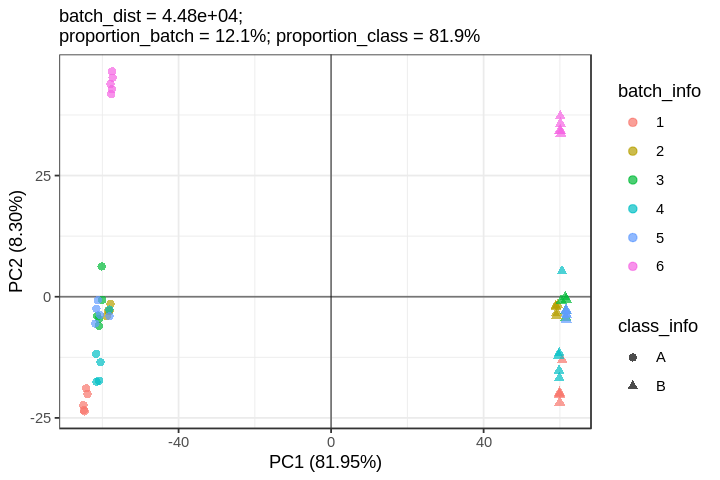

In [45]:
vars <- calc_var_prop(log_nozero, metadata)
dists <- calc_batch_dist(log_nozero, metadata)
ax <- ggplot_pca(
  log_nozero, metadata,
  col = 'batch_info', pch = 'class_info'
) +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax
ggsave('~/Dropbox/tmp/maqc_pca-nozero_log_tms.pdf',
       ax, width = 6, height = 4)

In [19]:
# gmean <- function(x) exp(mean(log(x[x > 0])))

In [36]:
# divide by no. of non-zero values
trim <- 0.02
tm_affy <- sapply(raw_affy, mean, trim = trim)
mean_nonzero_affy <- colSums(raw_affy) / colSums(raw_affy != 0)

affyms_factor <- 500 / tm_affy
affyms_maqc <- sweep(raw_maqc, 2, affyms_factor, `*`)

log_affyms_maqc <- affyms_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

log_affyms_nozero <- log_affyms_maqc[rowSums(log_affyms_maqc == 0) == 0, ]

[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


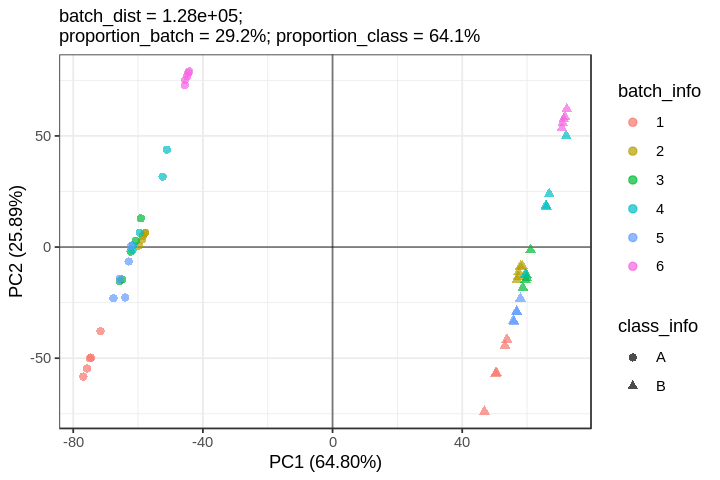

In [37]:
vars <- calc_var_prop(log_affyms_nozero, metadata)
dists <- calc_batch_dist(log_affyms_nozero, metadata)

ax <- ggplot_pca(
  log_affyms_nozero, metadata,
  col = 'batch_info', pch = 'class_info'
) +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax
# ggsave('~/Dropbox/tmp/maqc_pca-nozero_log_affyms_trim_matched.pdf',
#        ax, width = 6, height = 4)

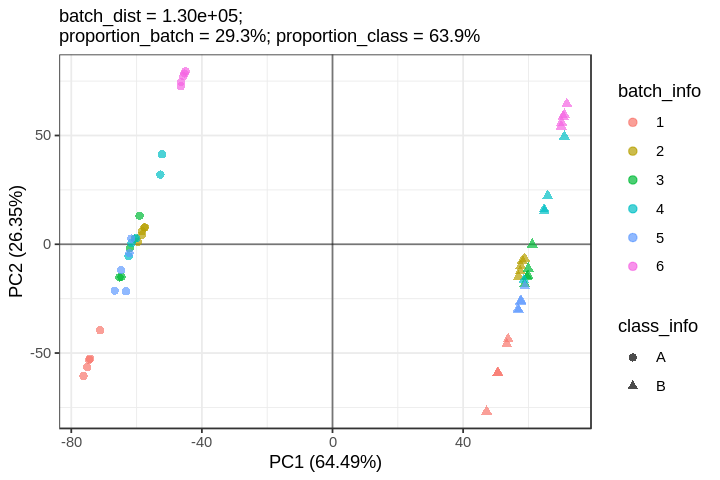

In [233]:
# imputed affy
vars <- calc_var_prop(log_affyimp_nozero, metadata)
dists <- calc_batch_dist(log_affyimp_nozero, metadata)
ax <- ggplot_pca(
  log_affyimp_nozero, metadata,
  col = 'batch_info', pch = 'class_info'
) +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax
# ggsave('~/Dropbox/tmp/maqc_pca-nozero_log_affyimp_trim_matched.pdf',
#        ax, width = 6, height = 4)

In [115]:
source("../../R/predict.R")

In [116]:
trim <- 0.02
scaled_maqc <- scale_batch_affy(raw_maqc, metadata, idx_affy, trim = trim)

Class A (median slope = 0.073):
Scaled batch 1 with original slope of 0.055 to 0.073
Scaled batch 2 with original slope of 0.074 to 0.073
Scaled batch 3 with original slope of 0.071 to 0.073
Scaled batch 4 with original slope of 0.086 to 0.073
Scaled batch 5 with original slope of 0.067 to 0.073
Scaled batch 6 with original slope of 0.113 to 0.073

Class B (median slope = 0.074):
Scaled batch 1 with original slope of 0.059 to 0.074
Scaled batch 2 with original slope of 0.073 to 0.074
Scaled batch 3 with original slope of 0.074 to 0.074
Scaled batch 4 with original slope of 0.113 to 0.074
Scaled batch 5 with original slope of 0.066 to 0.074
Scaled batch 6 with original slope of 0.113 to 0.074



In [117]:
# divide by no. of non-zero values
tm_affy <- sapply(raw_affy, mean, trim = trim)
avg_nonzero_affy <- colSums(raw_affy) / colSums(raw_affy != 0)
affyms_factor <- 500 / tm_affy

affybms_maqc <- sweep(scaled_maqc, 2, affyms_factor, `*`)

log_affybms_maqc <- affybms_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

log_affybms_nozero <- log_affybms_maqc[
  rowSums(log_affybms_maqc == 0) == 0, ]

[1] "No. of ambiguous and AFFY probesets removed: 17258"
[1] "No. of probesets removed = 18820"


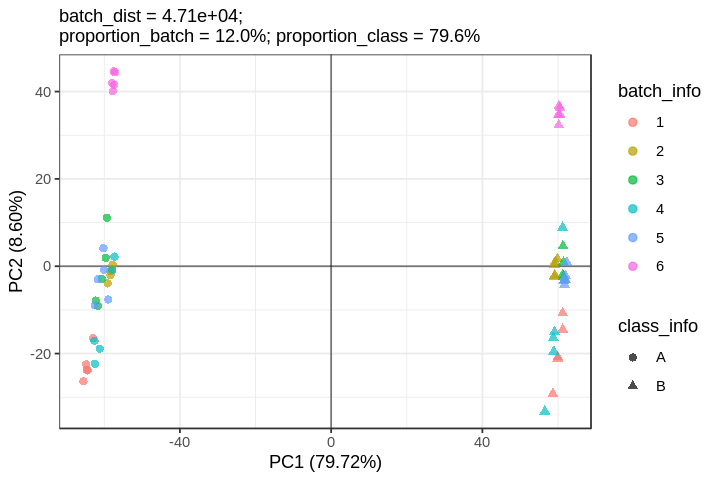

In [118]:
vars <- calc_var_prop(log_affybms_nozero, metadata)
dists <- calc_batch_dist(log_affybms_nozero, metadata)
ax <- ggplot_pca(
  log_affybms_nozero, metadata,
  col = 'batch_info', pch = 'class_info'
) +
  labs(subtitle = sprintf(
    "batch_dist = %.2e;\nproportion_batch = %.1f%%; proportion_class = %.1f%%",
    sum(dists), vars['var_batch'] * 100, vars['var_class'] * 100
  ))
ax

ggsave('~/Dropbox/tmp/maqc_pca-nozero_log_affybms_trim02_cls.pdf',
       ax, width = 6, height = 4)

#### Plot: Top PCs

In [140]:
ax1 <- ggplot_top_pc(
  log_maqc, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ax2 <- ggplot_top_pc(
  log_affyms_maqc, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ax3 <- ggplot_top_pc(
  log_affybms_maqc, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ggsave('~/Dropbox/tmp/maqc_top_pc-log_affybms.pdf',
       ax3, width = 8, height = 4)

In [145]:
ax1 <- ggplot_top_pc(
  log_nozero, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ax2 <- ggplot_top_pc(
  log_affyms_nozero, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ax3 <- ggplot_top_pc(
  log_affybms_nozero, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ggsave('~/Dropbox/tmp/maqc_top_pc-nozero_log_affybms.pdf',
       ax3, width = 8, height = 4)

### Investigation

In [201]:
log_raw <- log2_transform(raw_maqc)

In [241]:
a1_2 <- log_raw[['AFX_2_A1']]
a2_2 <- log_raw[['AFX_2_A2']]
a3_2 <- log_raw[['AFX_2_A3']]
b1_2 <- log_raw[['AFX_2_B1']]
b2_2 <- log_raw[['AFX_2_B2']]

a1_3 <- log_raw[['AFX_3_A1']]
a2_3 <- log_raw[['AFX_3_A2']]
a3_3 <- log_raw[['AFX_3_A3']]
b1_3 <- log_raw[['AFX_3_B1']]
b2_3 <- log_raw[['AFX_3_B2']]

a1_5 <- log_raw[['AFX_5_A1']]
a2_5 <- log_raw[['AFX_5_A2']]
a3_5 <- log_raw[['AFX_5_A3']]
b1_5 <- log_raw[['AFX_5_B1']]
b2_5 <- log_raw[['AFX_5_B2']]

a1_6 <- log_raw[['AFX_6_A1']]
a2_6 <- log_raw[['AFX_6_A2']]
b1_6 <- log_raw[['AFX_6_B1']]
b2_6 <- log_raw[['AFX_6_B2']]

In [235]:
x <- log_maqc[, 1]
max(x[x != 0])

[1] 16.13905

In [232]:
max(a1_5[a1_5 != 0])

[1] 13.70946

#### Mean v.s. variance (raw)

In [140]:
class_a <- subset_cols(raw_maqc, metadata, class_info == 'A')

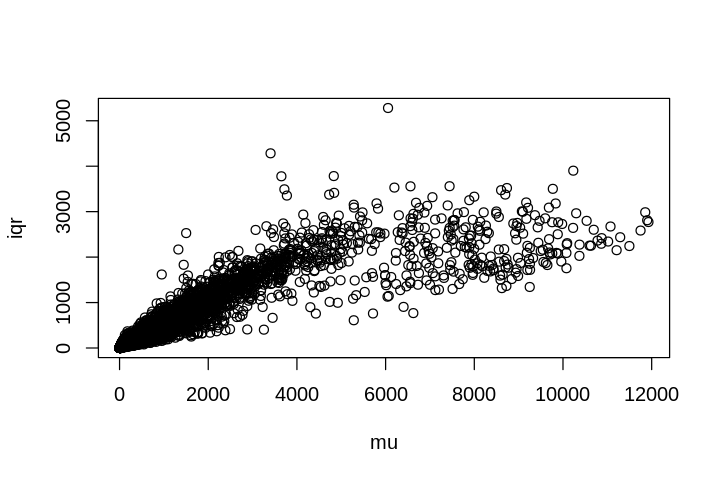

In [141]:
mu <- rowMeans(class_a)
sigma <- apply(class_a, 1, sd)
iqr <- apply(class_a, 1, IQR)

In [153]:
pdf('~/Dropbox/tmp/maqc_mean_sd-class_a_affy.pdf', width = 5, height = 5)
plot(mu[idx_affy], sigma[idx_affy])
dev.off()

png 
  2

In [161]:
x <- rnorm(100, 3, 1)
mu_x <- mean(x)
print(mu_x)
print(mean(2*x))
print(2*mu_x)

[1] 3.083309
[1] 6.166617
[1] 6.166617


### Observations
- sum_notaffy is around 100X larger than sum_affy
- Observe whether there are majority BE

In [461]:
tms_affy <- scaled_maqc[idx_affy, ]
affybms_affy <- affybms_maqc[idx_affy, ]

In [ ]:
# split into classes
# split into batches
# median of each batch
# median of medians to be reference
# use batch mean to compute scaling factor

# obtain beta matrix for each batch i by g
# quality check on matrix to make sure var is tight
# obtain beta vector

In [513]:
for (i in seq_along(rownames(tms_affy))) {
  print(i)
  value <- unlist(tms_affy[i, ])
  x_y <- data.frame(value, metadata[names(value), ])

  ax <- ggplot(x_y) +
    geom_point(
      aes(x = batch_info, y = value, pch = class_info, colour = batch_info),
      position = position_jitterdodge()
    ) +
    labs(title = rownames(tms_affy)[i])
  file <- sprintf("~/Dropbox/tmp/tms_affy-%d.pdf", i)
  ggsave(file, ax, width = 6, height = 4)
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58


In [689]:
for (i in seq(50)) {
  print(i)
  value <- unlist(scaled_maqc[i, ])
  x_y <- data.frame(value, metadata[names(value), ])

  ax <- ggplot(x_y) +
    geom_point(
      aes(x = batch_info, y = value, colour = batch_info, pch = class_info),
      position = position_jitterdodge()
    ) +
    labs(title = rownames(scaled_maqc)[i])
  
  file <- sprintf("~/Dropbox/tmp/tms_notaffy-%d.pdf", i)
  ggsave(file, ax, width = 6, height = 4)
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50


In [464]:
for (i in seq_along(rownames(affybms_affy))) {
  print(i)
  value <- log2_transform(unlist(affybms_affy[i, ]))
  x_y <- data.frame(value, metadata[names(ps), ])

  ax <- ggplot(x_y) +
    geom_point(
      aes(x = batch_info, y = value, pch = class_info, colour = batch_info),
      position = position_jitterdodge()
    ) +
    labs(title = names(value)[i]) +
    ylim(0, 16)
  
  file <- sprintf("~/Dropbox/tmp/affybms_affy-%d.pdf", i)
  ggsave(file, ax, width = 6, height = 4)
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58


In [ ]:
# Investigate additive batch effects --------------------------------------
par(mfrow=c(1,2))
plot(log_maqc[,1], log_maqc[,11])
plot(log_maqc[,1], log_maqc[,2])

hist(log_maqc[,11] - log_maqc[,1], breaks = 50)
error_1 <- filtered_maqc[,11] - filtered_maqc[,1]

sub_error_1 <- error_1[abs(error_1) < 5000]
hist(sub_error_1, breaks = 50)
hist(rnorm(5000, 0, 2000), breaks = 50)

rlaplace <- function(n, mu, b) {
  X <- runif(n, -0.5, 0.5)
  mu - b*sign(X)*log(1-2*abs(X))  
}
hist(rlaplace(1000,0,1000), breaks = 20)

k <- 0.2
beta <- 0.001
hist(y, breaks = 50)
hist(sub_error_1, breaks = 50)

error_2 <- c(rgamma(1000, k, beta), -1 * rgamma(1000, k, beta))

# COMPARISON (EQUAL) ---------------------------------------------------------------
# No normalisation
class_letter <- ifelse(class_info == 1, "A", "B")
plot_before <- plot_batch(log_maqc, batch_info, class_letter)

foo_data <- data.frame(A = 1:10, B = 1:10)
batch_factor <- as.factor(1:10)
shape_factor <- rep(c("D0","D8","N"), c(3,3,4))

plot_foo <- ggplot(foo_data, aes(x = A, y = B, col = batch_factor, shape = shape_factor)) +
  geom_point(size = 3, show.legend = T) +
  scale_colour_manual(values = batch_palette) +
  scale_shape_manual(values=21:23) +
  labs(shape="Class", colour="Batch")

plot_foo
ggsave("dump/all_legend.pdf", plot_foo,
       width = 8, height = 8)

# ggsave("dump/plot_before.pdf", plot_before,
#        width = 6, height = 6)
# 
# selected_probesets <- filter_probesets(raw_maqc, 0.98)
# filtered_maqc <- raw_maqc[selected_probesets,]
# nrow(filtered_maqc)
# filtered_plot <- plot_batch(filtered_maqc, batch_info, shape_info)
# filtered_plot
# 
# # Mean-scaling
# scaled_maqc <- norm_mean_scaling(raw_maqc)
# plot_scaled <- plot_batch(scaled_maqc, batch_info, shape_info)
# plot_scaled
# ggsave("dump/plot_scaled.pdf", plot_scaled,
#        width = 6, height = 6)
# 
# # CDF
# rank_maqc <- norm.cdf(raw_maqc)
# plot_batch(rank_maqc, batch_info, shape_info)
# 
# # GFS
# gfs_maqc <- norm_gfs(raw_maqc)
# plot_gfs <- plot_batch(gfs_maqc, batch_info, shape_info)
# ggsave("dump/plot_gfs.pdf", plot_gfs,
#        width = 6, height = 6)

# MNN
# Split dataframe according to batch info
list_df <- split.default(filtered_maqc, batch_info)
# Convert df to arr
list_arr <- lapply(list_df, data.matrix)
list_args <- c(list_arr, k = 5, cos.norm.out = F)
mnn_maqc_obj <- do.call(mnnCorrect, list_args)
mnn_maqc_arr <- do.call(cbind, mnn_maqc_obj$corrected)
# Column names for matrix arranged in above order
colnames(mnn_maqc_arr) <- colnames(log_maqc)
plot_mnn <- plot_batch(data.frame(mnn_maqc_arr), batch_info, class_info)
plot_mnn

ggsave("dump/plot_mnn_log_scaled_k5.pdf", plot_mnn_log_scaled,
       width = 6, height = 6)

# Investigate MNNs ability to correct for multiplicative error

# Quantile normalisation
col_indx <- substring(colnames(log_maqc), 7, 7) == "A"
qnorm_a <- norm.quantile(log_maqc[,col_indx])
qnorm_b <- norm.quantile(log_maqc[,!col_indx])
qnorm_maqc <- cbind(qnorm_a, qnorm_b)
colnames(qnorm_maqc)
plot_qnorm <- plot_batch(qnorm_maqc, batch_info, class_info)
plot_qnorm
ggsave("dump/plot_class_qnorm.pdf", plot_qnorm,
       width = 6, height = 6)

# Harman
harman_obj <- harman(scaled_maqc, class_info, batch_info)
harman_maqc <- data.frame(reconstructData(harman_obj))

plot_harman <- plot_batch(harman_maqc, batch_info, class_info)
plot_harman
ggsave("dump/plot_harman.pdf", plot_harman,
       width = 6, height = 6)

# Scanorama
# Write log_maqc for numpy array
write.table(log_maqc, "data/scanorama/log_maqc.tsv",
            quote = F, sep = "\t", row.names = F, col.names = F)
write(rownames(log_maqc), file = "data/scanorama/probeset_names.txt")

scanorama_maqc <- read.table("data/scanorama/scanorama_data_k10.tsv",
                             sep = "\t", row.names = 1)
colnames(scanorama_maqc) <- colnames(log_maqc)
plot_scanorama <- plot_batch(scanorama_maqc, batch_info, class_info)
plot_scanorama
ggsave("dump/plot_scanorama_k10.pdf", plot_scanorama,
       width = 6, height = 6)

# ComBat ------------------------------------------------------------------
# Creation of pData dataframe (metadata)
class <- as.factor(class_info)
batch <- as.factor(batch_info)
maqc_metadata <- data.frame(class, batch)
# Rownames of metadata are same as colnames of data df
rownames(maqc_metadata) <- colnames(raw_maqc)
head(maqc_metadata)
# Place adjustment/confounding variables in model.matrix (e.g. age)
# Do not put batch variables in model.matrix
# Put batch variables directly in combat function
# model_combat <- model.matrix(~1, data = maqc_metadata)
# Include biological variable of interest as covariate
model_combat <- model.matrix(~class, data = maqc_metadata)

combat_maqc <- ComBat(data.matrix(filtered_maqc),
                      batch = maqc_metadata$batch,
                      mod = model_combat)
combat_maqc_df <- data.frame(combat_maqc)
# Replace negative values with 0
combat_maqc_df[combat_maqc_df < 0] <- 0

plot_combat <- plot_batch(combat_maqc_df, batch_info, class_info)
plot_combat

ggsave("dump/plot_FSL_combatCovariate.pdf", plot_combat,
       width = 6, height = 6)

# Log-transform data after mean-scaling
log_maqc <- log2_transform(filtered_maqc)
combat_log_maqc <- ComBat(data.matrix(log_maqc),
                          batch = maqc_metadata$batch,
                          mod = model_combat)
combat_log_maqc_df <- data.frame(combat_log_maqc)
# Replace negative values with 0
combat_log_maqc_df[combat_log_maqc_df < 0] <- 0

plot_combat_log_scaled <- plot_batch(combat_log_maqc_df, batch_info, shape_info)
ggsave("dump/plot_combat_log_scaled.pdf", plot_combat_log_scaled,
       width = 6, height = 6)

# CBC ---------------------------------------------------------------------
class_info <- ifelse(class_info == 1, "A", "B")
cbc_maqc <- norm.CBC(log_maqc, batch_info, class_info, 1:6, "dump/correction_log_maqc.tsv")

plot_cbc <- plot_batch(cbc_maqc, batch_info, class_info)
plot_cbc

ggsave("dump/plot_cbc.pdf", plot_cbc,
       width = 6, height = 6)

# Apply log first before scaling or normalisation
log_maqc <- log2_transform(raw_maqc)
scaled_log_maqc <- norm.mean_scaling(log_maqc)
cbc_scaled_log_maqc <- norm.CBC(scaled_log_maqc, batch_info, class_info, 1:6)
plot_log_raw <- plot_batch(log_maqc, batch_info, class_info)
plot_scaled_log <- plot_batch(scaled_log_maqc, batch_info, class_info)
plot_scaled_log
plot_cbc_scaled_log <- plot_batch(cbc_scaled_log_maqc, batch_info, class_info)

# Log-transform after scaling but before batch correction
log_scaled_maqc <- log2_transform(scaled_maqc)
cbc_log_scaled_maqc <- norm.CBC(log_scaled_maqc, batch_info, class_info, 1:6)
plot_cbc_log_scaled <- plot_batch(cbc_log_scaled_maqc, batch_info, class_info)
plot_log_cbc_log_scaled <- plot_batch(log2_transform(cbc_log_scaled_maqc), batch_info, class_info)

ggsave("dump/plot_cbc_log_scaled.pdf", plot_cbc_log_scaled,
       width = 6, height = 6)
ggsave("dump/plot_log_cbc_log_scaled.pdf", plot_log_cbc_log_scaled,
       width = 6, height = 6)

# PROPORTION DATASET --------------------------------------------------------
# Selects samples such that each batch has a diff proportion of classes
# Proportions rep(rep(LETTERS[1:2], 6), c(5,5,4,5,5,4,3,5,5,3,3,4))
selection_index <- c(1:10,11:14,16:20,21:25,26:29,31:33,36:40,41:45,46:48,51:53,56:59)
odd_maqc <- log_maqc[,selection_index]
odd_batch_info <- rep(1:6, c(10,9,9,8,8,7))
odd_class_info <- substring(colnames(odd_maqc), 7, 7)
odd_class_numeric <- ifelse(odd_class_info == "A", 1, 2)
odd_class_numeric
# TODO: SHOULD FILTER AGAIN!

ketchum <- eval.batch_effects(odd_maqc, odd_batch_info, odd_class_numeric)

pca_plot <- plot_batch(odd_maqc, odd_batch_info, odd_class_info)
pca_plot
ggsave("dump/pca_odd_maqc-uncorrected.pdf", pca_plot,
       width = 8, height = 4)

# Quantile
quantile_maqc <- norm.quantile(odd_maqc)
ketchum <- eval.batch_effects(quantile_maqc, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, quantile_maqc)

# ComBat
# Creation of pData dataframe (metadata)
class <- as.factor(odd_class_info)
batch <- as.factor(odd_batch_info)
odd_maqc_metadata <- data.frame(class, batch)
# Rownames of metadata are same as colnames of data df
rownames(odd_maqc_metadata) <- colnames(odd_maqc)
head(odd_maqc_metadata, 20)

# ComBat assumes that data has been normalised and probesets have been filtered
# Error if probesets are not filtered as rows have 0 variance

# Place adjustment/confounding variables in model.matrix (e.g. age)
# Do not put batch variables in model.matrix
# Put batch variables directly in combat function
# Only include intercept term in design matrix
model_combat <- model.matrix(~1, data = odd_maqc_metadata)

# # Include biological variable of interest as covariate
# model_combat <- model.matrix(~class, data = odd_maqc_metadata)

combat_maqc <- ComBat(data.matrix(odd_maqc),
                      batch = odd_maqc_metadata$batch,
                      mod = model_combat)
combat_maqc_df <- data.frame(combat_maqc)
# Replace negative values with 0
combat_maqc_df[combat_maqc_df < 0] <- 0

plot_combat_log_scaled <- plot_batch(combat_maqc_df, odd_batch_info, odd_class_info)
plot_combat_log_scaled

ggsave("dump/pca_odd_maqc-combat_i.pdf", plot_combat_log_scaled,
       width = 8, height = 4)

ketchum <- eval.batch_effects(combat_maqc_df, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, combat_maqc_df)

# CBC
cbc_maqc <- norm.BCM(odd_maqc, odd_batch_info, odd_class_info, 3)
colnames(cbc_maqc)
plot_cbc <- plot_batch(cbc_maqc, odd_batch_info, odd_class_info)
plot_cbc
ggsave("dump/pca_odd_maqc-bcm_ref.pdf", plot_cbc,
       width = 8, height = 4)

ketchum <- eval.batch_effects(cbc_maqc, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, cbc_maqc)

# Harman
harman_obj <- harman(odd_maqc, odd_class_info, odd_batch_info, limit = 0.95)

harman_maqc <- data.frame(reconstructData(harman_obj))
# Replace negative values with 0
harman_maqc[harman_maqc < 0] <- 0

plot_harman_odd <- plot_batch(harman_maqc, odd_batch_info, odd_class_info)
plot_harman_odd
ggsave("dump/pca_odd_maqc-harman.pdf", plot_harman_odd,
       width = 8, height = 4)

ketchum <- eval.batch_effects(harman_maqc, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, harman_maqc)

pca_coord <- plot_batch(harman_maqc, odd_batch_info, odd_class_info)
rownames(pca_coord)
harman_pc1 <- pca_coord[,1, drop = F]

list_pc1 <- split.data.frame(harman_pc1, odd_batch_info)
sapply(list_pc1, colMeans)

# CS-Harman
# Error: Require more than one experimental factor and/or batch for experimentstructure
list_maqc <- split.default(odd_maqc, odd_class_info)
list_batch_info <- lapply(list_maqc, function(df1) substring(colnames(df1),5,5))
list_class_info <- split(odd_class_info, odd_class_info)
list_harman_obj <- mapply(harman, list_maqc, list_class_info, list_batch_info, limit = 0.95)

str(list_maqc)
harman(list_maqc[[1]], rep("A", 25), rep(1:2, c(12,13)), limit = 0.95)
# Unable to run one batch
harman(list_maqc[[1]], rep(LETTERS[1:2], c(24,1)), rep(1, 25), limit = 0.95)

pca_obj <- prcomp(t(list_maqc[[1]]))
pca_arr <- pca_obj$x
batch_info99 <- substring(rownames(pca_arr), 5, 5)
plot(pca_arr[,1:2], col = batch_info99)

# Scanorama
# Write log_maqc for numpy array
write.table(odd_log_maqc, "data/scanorama/odd_log_maqc.tsv",
            quote = F, sep = "\t", row.names = F, col.names = F)
# Read scanorama corrected data
scanorama_maqc_odd <- read.table("data/scanorama/maqc/scanorama_data_odd_k20.tsv",
                                 sep = "\t", row.names = 1)
colnames(scanorama_maqc_odd) <- colnames(odd_maqc)

plot_scanorama_odd <- plot_batch(scanorama_maqc_odd,
                                 odd_batch_info, odd_class_info)
plot_scanorama_odd
ggsave("dump/pca_odd_maqc-scanorma_k20.pdf", plot_scanorama_odd,
       width = 8, height = 4)

ketchum <- eval.batch_effects(scanorama_maqc_odd, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, scanorama_maqc_odd)

# MNN
list_small_df <- split.default(odd_maqc, odd_batch_info)
list_small_arr <- lapply(list_small_df, data.matrix)

list_args <- c(list_small_arr, k = 7, cos.norm.out = F)
mnn_maqc_obj <- do.call(mnnCorrect, list_args)
mnn_maqc_odd <- do.call(cbind, mnn_maqc_obj$corrected)
# Column names for matrix arranged in above order
colnames(mnn_maqc_odd) <- colnames(odd_maqc)

mnn_maqc_odd[mnn_maqc_odd < 0] <- 0
mnn_maqc_df <- data.frame(mnn_maqc_odd)

plot_mnn_odd_k7 <- plot_batch(mnn_maqc_df,
                              odd_batch_info, odd_class_info)
plot_mnn_odd_k7

ggsave("dump/pca_odd_maqc-mnn_k7.pdf", plot_mnn_odd_k7,
       width = 8, height = 4)

ketchum <- eval.batch_effects(mnn_maqc_df, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, mnn_maqc_df)

# SMALL DATASET -----------------------------------------------------------
small_index <- 1:3 + rep(seq(0,55,5), each = 3)
small_maqc <- raw_maqc[,small_index]
small_batch_info <- rep(1:6, each = 6)
small_class_info <- substring(colnames(small_maqc), 7, 7)
# Scale and log-transform odd_maqc
small_scaled_maqc <- norm.mean_scaling(small_maqc)
small_log_maqc <- log2_transform(small_scaled_maqc)

# Scanorama
# Write small_log_maqc for numpy array
write.table(small_log_maqc, "data/scanorama/small_log_maqc.tsv",
            quote = F, sep = "\t", row.names = F, col.names = F)
# Read scanorama corrected data
scanorama_maqc_small <- read.table("data/scanorama/scanorama_data_small_k15.tsv",
                                   sep = "\t", row.names = 1)
colnames(scanorama_maqc_small) <- colnames(small_log_maqc)
plot_scanorama_small <- plot_batch(scanorama_maqc_small,
                                   small_batch_info, small_class_info)
plot_scanorama_small
ggsave("dump/plot_scanorama_small_k15.pdf", plot_scanorama_small,
       width = 6, height = 6)

# ComBat
# Creation of pData dataframe (metadata)
class <- as.factor(small_class_info)
batch <- as.factor(small_batch_info)
maqc_metadata <- data.frame(class, batch)
# Rownames of metadata are same as colnames of data df
rownames(maqc_metadata) <- colnames(small_maqc)
head(maqc_metadata, 20)

# ComBat assumes that data has been normalised and probesets have been filtered
# Error if probesets are not filtered as rows have 0 variance
selected_probetsets <- filter_probesets(small_log_maqc, 0.1)
filtered_maqc <- small_log_maqc[selected_probetsets,]
# Place adjustment/confounding variables in model.matrix (e.g. age)
# Do not put batch variables in model.matrix
# Put batch variables directly in combat function
model_combat <- model.matrix(~1, data = maqc_metadata)
combat_maqc <- ComBat(data.matrix(filtered_maqc),
                      batch = maqc_metadata$batch,
                      mod = model_combat)
combat_maqc_df <- data.frame(combat_maqc)
# Replace negative values with 0
combat_maqc_df[combat_maqc_df < 0] <- 0

plot_combat_log_scaled_small <- plot_batch(combat_maqc_df, small_batch_info, small_class_info)
plot_combat_log_scaled_small

ggsave("dump/plot_combat_log_scaled_small.pdf", plot_combat_log_scaled_small,
       width = 6, height = 6)

# CBC
cbc_maqc_small <- norm.CBC(small_log_maqc, small_batch_info, small_class_info, 1:6)
plot_cbc_log_scaled_small <- plot_batch(cbc_maqc_small, small_batch_info, small_class_info)
plot_cbc_log_scaled_small
ggsave("dump/plot_cbc_log_scaled_small.pdf", plot_cbc_log_scaled_small,
       width = 6, height = 6)

# MNN - Scaled
small_log_arr <- data.matrix(small_log_maqc)
list_small_df <- split.default(small_log_maqc, rep(1:6, each = 6))
list_small_arr <- lapply(list_small_df, data.matrix)
list_args <- c(list_small_arr, k = 3, cos.norm.out = T)
mnn_maqc_obj <- do.call(mnnCorrect, list_args)

# # Ordered according to number of samples in batch
# mnn_maqc_obj <- mnnCorrect(scaled_arr[,1:10],
#                            scaled_arr[,11:20],
#                            scaled_arr[,21:30],
#                            scaled_arr[,31:40],
#                            scaled_arr[,41:50],
#                            scaled_arr[,51:60],
#                            k = 5)

mnn_maqc <- do.call(cbind, mnn_maqc_obj$corrected)
# Column names for matrix arranged in above order
colnames(mnn_maqc) <- colnames(small_log_maqc)

# Replace negative values with zeros
plot_mnn_log_scaled_small <- plot_batch(data.frame(mnn_maqc), small_batch_info, small_class_info)
plot_mnn_log_scaled_small

ggsave("dump/plot_mnn_log_scaled_small_k3.pdf", plot_mnn_log_scaled_small,
       width = 6, height = 6)

# Harman
harman_obj <- harman(small_log_maqc, small_class_info,
                     small_batch_info, limit = 0.95)
harman_maqc <- data.frame(reconstructData(harman_obj))

plot_harman_small <- plot_batch(harman_maqc, small_batch_info, small_class_info)
plot_harman_small
ggsave("dump/plot_harman_log_scaled_small.pdf", plot_harman_small,
       width = 6, height = 6)


# EXPLORE -----------------------------------------------------------------
# No normalisation
plot_before <- plot_batch(raw_maqc, batch_info, shape_info)
plot_before
ggsave("dump/plot_before.pdf", plot_before,
       width = 6, height = 6)

# Select only rows with all zeros
no_zero_maqc <- raw_maqc[rowSums(raw_maqc == 0) == 0,]
filtered_plot <- plot_batch(no_zero_maqc, batch_info, shape_info)
# Selecting only probesets without zeros accentuates the batch effects
filtered_plot

batch_1_A <- raw_maqc[,1:5]
batch_2_A <- raw_maqc[,11:15]
batch_1_2_A <- cbind(batch_1_A, batch_2_A)
# Select only rows with all zeros
filtered_1_2_A <- batch_1_2_A[rowSums(batch_1_2_A == 0) == 0,]
rank_1_2_A <- apply(filtered_1_2_A, 2, rank)
rank_1_A <- rank_1_2_A[,1:5]
rank_2_A <- rank_1_2_A[,6:10]

batch_1_A_sd <- apply(rank_1_A, 1, sd)
batch_2_A_sd <- apply(rank_2_A, 1, sd)
hist(batch_1_A_sd, breaks = 60)
hist(batch_2_A_sd, breaks = 60)
low_ps <- names(batch_1_A_sd[batch_1_A_sd < 100])
high_ps <- names(batch_1_A_sd[batch_1_A_sd > 2000])
# Most of the probesets with low sd in ranks are highly expressed
rank_1_A[high_ps,]
# 22155 probesets
dim(rank_1_A)
# Ratio of technical variation to signal
# If ratio passed threshold of one (MAYBE)

batch_1_B <- raw_maqc[,6:10]
batch_2_B <- raw_maqc[,16:20]
batch_1_2_B <- cbind(batch_1_B, batch_2_B)
# Select only rows with all zeros
filtered_1_2_B <- batch_1_2_B[rowSums(batch_1_2_B == 0) == 0,]
rank_1_2_B <- apply(filtered_1_2_B, 2, rank)
rank_1_B <- rank_1_2_B[,1:5]
rank_2_B <- rank_1_2_B[,6:10]

batch_1_B_sd <- apply(rank_1_B, 1, sd)
batch_2_B_sd <- apply(rank_2_B, 1, sd)
hist(batch_1_B_sd, breaks = 60)
hist(batch_2_B_sd, breaks = 60)
rank_diff_B <- rowMeans(rank_1_B) - rowMeans(rank_2_B)
hist(rank_diff_B, breaks = 60)
little_change_B <- names(rank_diff_B[rank_diff_B > -1 & rank_diff_B < 1])
rank_1_B[little_change_B,]
rank_2_B[little_change_B,]

# Selection of probesets
# Do not select probesets with high variance (Technical and biological variance)
rank_diff_A <- rowMeans(rank_1_A) - rowMeans(rank_2_A)
batch_1_A_sd[1:10] 
batch_2_A_sd[1:10]
mean(rank_diff)
sd(rank_diff)
hist(rnorm(20000,0,1688), breaks = 80, col = "lightblue")
hist(rank_diff, breaks = 80, col = "tomato")

# PCA loadings ------------------------------------------------------------
col_logical <- apply(t(df), 2, var) != 0
pca_df <- t(df)[, col_logical]
pca_obj <- prcomp(pca_df, center = T, scale. = T)
top_pc <- as.data.frame(pca_obj$x[,1:2])

df <- scaled_maqc
col_logical <- apply(t(df), 2, var) != 0
pca_df <- t(df)[, col_logical]
pca_obj <- prcomp(pca_df, center = T, scale. = T)
top_pc <- as.data.frame(pca_obj$x[,1:2])
hist(pca_obj$rotation[,3], breaks = 50)
loading_1 <- pca_obj$rotation[,1]
head(loading_1)
sorted_loading_1 <- sort(abs(loading_1), decreasing = T)
head(sorted_loading_1)

loading_2 <- pca_obj$rotation[,2]
sorted_loading_2 <- sort(abs(loading_2), decreasing = T)
ps_2 <- names(head(sorted_loading_2, 2000))

loading_3 <- pca_obj$rotation[,3]
sorted_loading_3 <- sort(abs(loading_3), decreasing = T)
ps_3 <- names(head(sorted_loading_3, 2000))
union_ps <- union(ps_2, ps_3)
loading_3[intersect_ps]
loading_2[intersect_ps]

subset_maqc <- scaled_maqc[union_ps,]
sample_maqc <- scaled_maqc[,1]
dim_maqc <- nrow(scaled_maqc)
quantile_maqc <- 1:dim_maqc/dim_maqc

View(subset_maqc)
# Filter out probesets that are heavily loaded in PC2 and PC3
filtered_scaled <- scaled_maqc[!(rownames(scaled_maqc) %in% union_ps),]
plot_filtered <- plot_batch(filtered_scaled, batch_info, shape_info)
plot_filtered

scaled_maqc <- norm.mean_scaling(raw_maqc)
plot_scaled <- plot_batch(scaled_maqc, batch_info, shape_info)
plot_scaled

# 20191209 ----------------------------------------------------------------
subset_maqc <- log_maqc[,1:20]

bcm_maqc <- correctRefBCM(log_maqc, metadata_df, 1)
plotPCA2D(subset_maqc, metadata_df)

pca_obj <- prcomp(t(subset_maqc))
# Identify batch effects features using loadings of PC2
batch_probesets <- names(sort(abs(pca_obj$rotation[,3]), decreasing = T))

# # Remove batch effects features
# corrected_maqc <- subset_maqc[!(rownames(subset_maqc) %in% batch_probesets),]
# dim(corrected_maqc)
dim(pca_obj$rotation)

par(mfrow=c(4,2))
par(mar=rep(2,4))
idx <- 2100*8+1
for(i in idx:(idx+7)) {
  y <- as.numeric(log_maqc[batch_probesets[i],])
  # bcm_y <- as.numeric(bcm_maqc[batch_probesets[i],])
  print(batch_probesets[i])
  plot(1:60, y, pch = rep(rep(21:22, each = 5), 6), main = batch_probesets[i],
       cex = 2, bg = rep(2:7, each = 10))
  # plot(1:60, bcm_y, pch = rep(rep(21:22, each = 5), 6),
  #      main = batch_probesets[i], cex = 2, bg = rep(2:7, each = 10))
}

interesting_probesets <- recordPlot()
idx
save_fig(interesting_probesets, "dump/pc3_16801th_probeset.pdf",
         width = 8, height = 10)

# Interesting probesets that are not heavily loaded in PC2 and PC3
differential_b1n2 <- c("212600_s_at", "202530_at", "232028_at", "1557167_at")
differential_rev_loadings <- pca_obj$rotation[differential_b1n2,]
apply(abs(differential_rev_loadings), 1, rank)
# Even though they are not heavily loaded in the PCs, the PCs still contribute
# most to the probeset!!!

# Smaller value smaller rank
loadings_rank <- apply(abs(pca_obj$rotation), 2, rank)
loadings_rank[differential_b1n2,]

# Fitting a linear model
y <- as.numeric(log_maqc["206766_at",])
batch_info <- as.factor(rep(1:6, each = 10))
class_info <- as.factor(rep(rep(LETTERS[1:2], each = 5), 6))
fitted_model <- lm(y ~ batch_info + class_info)
summary(fitted_model)

class_info
mean(y[1:5])

par(mfrow=c(1,1))
plot(1:60, y, col = batch_info)


# SELECT BATCH GENES ------------------------------------------------------
idx <- 1810*8
interesting_probesets <- log_maqc[batch_probesets[idx], ,
                                  drop = FALSE]
groups <- mapply(paste0, class_info, batch_info)

list_class <- split.default(interesting_probesets, groups)
list_classA <- list_class[grepl("A", names(list_class))]
` `
lapply(list_classA, median)

# for (i in 1:8) {
#   hist(log_maqc[,i], breaks = 50)
#   print(i)
# }

sampled_probesets <- subset_maqc[batch_probesets[idx:(idx+7)],]
write.table(sampled_probesets, "dump/sample_maqc_data.tsv",
            quote = F, sep = "\t")

probeset <- rownames(sample_maqc)[1]
plot(1:60, log_maqc[probeset,])
# Local batch effects (some classes are different)


# Investigate heavily loaded probesets

plotPCA2D(corrected_maqc, metadata_df)

bcm_maqc <- correctSVDBCM(subset_maqc, metadata_df, 1)
before_correction <- bcm_maqc$plot[[1]]
after_correction <- bcm_maqc$corrected_plot[[1]]                                                                                                                                                                                                                                                                                         
after_rePCA <- plotPCA2D(bcm_maqc$data, metadata_df)
ggsave("dump/maqc-after_bcmsvd_pca.pdf", after_rePCA)

# Investigate correction vectors
correction_vectors <- read.table("history/correction_log_maqc.tsv",
                                 sep = "\t", header = T, row.names = 1)
hist(correction_vectors[,2], breaks = 100)

# INDIVIDUAL BATCH EFFECT GENES -------------------------------------------
# Between batch 1 and 2
b1n2 <- log_maqc[,1:20]
pca_obj <- prcomp(t(b1n2))
batch_probesets <- names(sort(pca_obj$rotation[,2], decreasing = TRUE))
b1n2[,batch_probesets[i]]

# Local Batch Effects? ----------------------------------------------------
# Correct batch 5 and 6
batch_5_6 <- scaled_maqc[40:60]
batch_info1 <- rep(1:2, each = 10)
class_info1 <- rep(rep(LETTERS[1:2], each = 5), 2)

# factor_batch <- as.factor(batch_info1)
# factor_class <- as.factor(class_info1)
# # Metadata dataframe
# metadata_df <- data.frame(factor_batch, factor_class)
# head(metadata_df)
# 
# levels(factor_class)
# 
# # Returns vector of batches for each class
# get_batch <- function(class) metadata_df[metadata_df$factor_class == class, "factor_batch"]
# class_batch_info <- lapply(levels(factor_class), get_batch)
# names(class_batch_info) <- levels(factor_class)

# Correct batch 5 and 6
batch_5_6 <- scaled_maqc[40:60]
batch_info1 <- rep(1:2, each = 10)
class_info1 <- rep(rep(LETTERS[1:2], each = 5), 2)

batch_5_A <- scaled_maqc[41:45]
batch_5_B <- scaled_maqc[46:50]
batch_6_A <- scaled_maqc[51:55]
batch_6_B <- scaled_maqc[56:60]
# Two correction vectors: Class A & B
# Anchor: Batch 5
correction_A <- rowMeans(batch_6_A) - rowMeans(batch_5_A) 
correction_B <- rowMeans(batch_6_B) - rowMeans(batch_5_B)
# Correction performed
corrected_6_A <- batch_6_A - correction_A
corrected_6_B <- batch_6_B - correction_B
# Change negative values to 0
corrected_6_A[corrected_6_A < 0] <- 0
corrected_6_B[corrected_6_B < 0] <- 0

corrected_maqc <- cbind(scaled_maqc[,1:50], corrected_6_A, corrected_6_B)

plot_batch(corrected_maqc, batch_info, shape_info)

# MODELLING ---------------------------------------------------------------
# Distributions of values across batches are very different
# Distributions of values within batches are similar
hist(log_maqc[,46],
     prob = T, col = "lightblue", breaks = 30)
hist(log_maqc[,42],
     prob = T, col = "pink", breaks = 30, add = T)

# Probesets with zero values
colnames(log_maqc)
list_maqc <- split.default(odd_maqc, odd_class_info)
list_batch_info <- lapply(list_maqc, function(df1) substring(colnames(df1),5,5))
list_class_info <- split(odd_class_info, odd_class_info)
list_harman_obj <- mapply(harman, list_maqc, list_class_info, list_batch_info, limit = 0.95)

colnames(log_maqc)
batch_1A <- log_maqc[,1:5]
batch_2A <- log_maqc[,11:15]
batch_3A <- log_maqc[,21:25]
batch_4A <- log_maqc[,31:35]
batch_5A <- log_maqc[,41:45]
batch_6A <- log_maqc[,51:55]

ps1 <- rownames(batch_1A)[rowSums(batch_1A) == 0]
ps2 <- rownames(batch_2A)[rowSums(batch_2A) == 0]
ps3 <- rownames(batch_3A)[rowSums(batch_3A) == 0]
ps4 <- rownames(batch_4A)[rowSums(batch_4A) == 0]
ps5 <- rownames(batch_5A)[rowSums(batch_5A) == 0]
ps6 <- rownames(batch_6A)[rowSums(batch_6A) == 0]

length(intersect(ps1,ps6))
length(setdiff(ps6,ps1))

length(ps1)
nrow(log_maqc)

# Probesets that are empty in all batches
all_empty <- Reduce(intersect, list(intersect(ps1,ps2), intersect(ps1,ps3), intersect(ps1,ps4),
                       intersect(ps1,ps5), intersect(ps1,ps6)))
length(all_empty)

# Probesets that are not present in batch 1 but present in other batches
absent_batch1 <- Reduce(intersect, list(setdiff(ps1,ps2), setdiff(ps1,ps3), setdiff(ps1,ps4),
                       setdiff(ps1,ps5), setdiff(ps1,ps6)))
# Probesets that are present in batch 1 but not all other batches
present_batch1 <- Reduce(intersect, list(setdiff(ps2,ps1), setdiff(ps3,ps1),
                       setdiff(ps4,ps1), setdiff(ps5,ps1), setdiff(ps6,ps1)))

absent_batch23456 <- Reduce(intersect, list(intersect(ps2,ps3), intersect(ps3,ps4),
                       intersect(ps5,ps6)))
absent_batch_real <- setdiff(absent_batch23456, ps1)

afflicted_logvec <- rownames(log_maqc) %in% c(present_batch1, absent_batch1)

plot_batch(log_maqc[afflicted_logvec,], batch_info, class_info)


class_pch <- ifelse(class_info == 1, 19, 17)
afflicted_maqc <- log_maqc[c(present_batch1, absent_batch1),]
afflicted_maqc <- log_maqc[absent_batch1,]
# Look at afflicted probesets
par(mfrow=c(2,2))
i <- 19
for (j in (4*i+1):(4*i+4)) {
  print(j)
  plot(1:60, afflicted_maqc[j,],
       axes = F, ann = F,
       col = batch_info, pch = class_pch)
}

# Does batch effects affect highly or lowly expressed genes?
plot_batch(log_maqc[,1:50], batch_info[1:50], class_info[1:50])

# PCA loadings
# Data without batch 5
subset_maqc <- log_maqc[,1:50]
pca_obj <- prcomp(t(subset_maqc), scale. = F)
pca_loading <- pca_obj$rotation

# PC2 loadings
pc2 <- pca_loading[,2]
# CONSIDER HIGH WEIGHTING REGARDLESS OF DIRECTION
pc2_ps <- names(sort(abs(pc2), decreasing = T))[1:500]
# sort(pc2, decreasing = T)[30000:31000]
class_pch <- ifelse(class_info == 1, 19, 17)

inspect_maqc <- log_maqc[pc2_ps, 1:50]
# Look at afflicted probesets
par(mfrow=c(2,2))
i <- 0
for (j in (4*i+1):(4*i+4)) {
  print(j)
  plot(1:60, afflicted_maqc[j,],
       axes = F, ann = F,
       col = batch_info[1:50], pch = class_pch[1:50])
}

# Magnitude of high-dimensional vectors do not vary alot
pca_obj1 <- prcomp(t(log_maqc))
# Magnitude of vectors in pca space
apply(pca_obj1$x, 1, calc.l2_norm)
# Magnitude of vectors in non-centered original space
apply(log_maqc, 2, calc.l2_norm)
# Magnitude of vectors in centered original space
apply(scale(log_maqc, scale = F), 2, calc.l2_norm)

### Local consistencies
# Consistencies in magnitude
plot_evaluation(log2_transform(raw_maqc), batch_info)

x <- log2_transform(norm.mean_scaling(raw_maqc))
colnames(x)
plot(x[,6], x[,7], main = "mean(raw_maqc) (B1B1 vs B1B2)")
plot(rowMeans(x[,1:5]), rowMeans(x[,11:15]), main = "log2(raw_maqc) (B1-MeanA vs B2-MeanA)")
abline(a=0, b = 1)
dev.copy(png, "dump/scatter_fig10.png")
dev.off()

plot_maqc <- plot_batch(x, batch_info, class_info)
plot_maqc

batch_factor <- as.factor(rep(1:2, each = 10))
class_factor <- as.factor(rep(rep(LETTERS[1:2], each = 5), 2))

corrected_df <- norm.CBC(x[,1:20], batch_factor, class_factor, c(1,2), "dump/log_mean_correction.tsv")

correction_vectors <- read.table("dump/log_mean_correction.tsv", sep = "\t")

plot_batch(corrected_df, batch_factor, class_factor)
plot(correction_vectors$A, correction_vectors$B)

A_avg <- rowMeans(x[,11:15])
B_avg <- rowMeans(x[,16:15])
observed_avg <- data.frame(A_avg, B_avg)
big_diff_ps <- names(A_avg)[abs(A_avg-B_avg) > 5 & A_avg != 0 & B_avg != 0]

par(mfrow=c(1,1))

for (i in 1:12) {
  probeset <- big_diff_ps[i]
  plot(unlist(observed_avg[probeset,]),
       unlist(correction_vectors[probeset,]))
  abline(a = 0, b = 1)
}

k_arr <- matrix(0, 54675, 2)
for (i in 1:54675) {
  k_arr[i,1] <- correction_vectors[i,1]/observed_avg[i,1]
  k_arr[i,2] <- correction_vectors[i,2]/observed_avg[i,2]
}

plot(k_arr[,1], k_arr[,2])

df <- data.frame(A_avg[1:10], A_avg[1:10])

head(correction_vectors)
head(observed_avg)

max(correction_vectors[,1])

x <- log2_transform(norm.mean_scaling(raw_maqc))
# B1A1 - B2A1
plot(x[,1]-x[,11], x[,4]-x[,15]) 
plot(x[,1]-x[,11], x[,1]-x[,11])

par(mfrow=c(1,1))

plot(x[,6], x[,16],
     main = "log2(mean(raw_maqc)) (B1B1 vs B2B1)")
abline(a=0, b = 1)
dev.copy(png, "dump/scatter_fig11.png")
dev.off()

plot(rowMeans(x[,1:5]), rowMeans(x[,11:15]),
     main = "log2(raw_maqc) (B1-MeanA vs B2-MeanA)")

plot_arr <- rowMeans(x[,1:5])
ggplot(data.frame(plot_arr)) +
  geom_jitter(aes(x = plot_arr, y = 0))

head(cbind(x[,1:5], x[,11:15]), 100)

# Select rows with all positive numbers
x_nozero <- x[rowSums(x == 0) == 0,]

nozero <- plot_batch(x_nozero, batch_info, class_info)
gotzero <- plot_batch(x, batch_info, class_info)
nozero
gotzero

correction_vectors <- read.table("dump/correction_log_maqc.tsv", sep = "\t")
head(correction_vectors)

# Calculate angle between vectors
cos_sim <- calc.cos_sim(correction_vectors$A, correction_vectors$B)
calc.rad2degree(acos(cos_sim))

hist(correction_vectors$A, breaks = 30)
hist(correction_vectors$B, breaks = 30)

plot(correction_vectors$A, correction_vectors$B)

par(mfrow=c(1,2))
plot(log_maqc[,1], log_maqc[,11], main = "B2A1 vs B1A1")
plot(log_maqc[,1], log_maqc[,2], main = "B1A2 vs B1A1")
plot_scatter <- recordPlot()
save_fig(plot_scatter, "dump/batch_effects.png")

dim(log_maqc)

plot_batch(log_maqc, batch_info, class_info)
eval.batch_effects(log_maqc, batch_info, class_info)

legit_maqc <- remove_probesets(log_maqc)
plot_batch(legit_maqc, batch_info, class_info)

pca_obj <- prcomp(t(legit_maqc))
probeset_pc1 <- names(head(sort(pca_obj$rotation[,1], decreasing = T), 1000))
probeset_pc2 <- names(head(sort(pca_obj$rotation[,2], decreasing = T), 1000))
probeset_pc3 <- names(head(sort(pca_obj$rotation[,3], decreasing = T), 1000))

probeset_batch <- intersect(probeset_pc2, probeset_pc3)

subdf_maqc <- legit_maqc[probeset_pc2,]

class_pch <- ifelse(class_info == 1, 19, 17)

par(mfrow=c(4,1)) 
num <- 500
for (i in num:(num+3)) {
  plot(as.numeric(subdf_maqc[i,]), axes = F, ann = F,
       col = batch_info, pch = class_pch)
}

# EVALUATION --------------------------------------------------------------
filtered_maqc <- raw_maqc[filter_probesets(raw_maqc, 0.1),]
scaled_maqc <- norm.mean_scaling(filtered_maqc)
log_maqc <- log2_transform(scaled_maqc)

plot_batch(log_maqc, batch_info, class_info)
# ANOVA
batch_info <- rep(LETTERS[1:6], each = 10)
df <- log_maqc
pca_obj <- prcomp(t(df), center = T, scale. = T)
pca_arr <- pca_obj$x
pca_df <- data.frame(pca_arr)
eig_value <- (pca_obj$sdev)^2
var_pct <- eig_value/sum(eig_value)

# Argument: PC coordinates for single PC
calc.pc_var <- function(vec) {
  # Argument: ANOVA attributes; Calculates percentage of variance
  # SS_between/SS_between + SS_within
  calc.var_percentage <- function(vec) unname(vec[3]/(vec[3] + vec[4]))
  pc_metadata <- data.frame(pc = vec,
                            batch = as.factor(batch_info),
                            class = as.factor(class_info))
  batch_anova_attr <- unlist(summary(aov(pc~batch, data = pc_metadata)))
  class_anova_attr <- unlist(summary(aov(pc~class, data = pc_metadata)))
  return(c(calc.var_percentage(batch_anova_attr),
           calc.var_percentage(class_anova_attr)))
}
var_composition <- sapply(pca_df, calc.pc_var)
pca_var_df <- data.frame(var_pct,
                         batch_pct = var_composition[1,],
                         class_pct = var_composition[2,])
total_batch_pct <- sum(pca_var_df$var_pct * pca_var_df$batch_pct)
total_class_pct <- sum(pca_var_df$var_pct * pca_var_df$class_pct)

# ANOVA (Odd)
odd_batch_info
filtered_odd_maqc <- odd_maqc[filter_probesets(odd_maqc, 0.1),]
df <- filtered_odd_maqc
pca_obj <- prcomp(t(df), center = T, scale. = T)
pca_arr <- pca_obj$x
odd_single_pc_df <- data.frame(pc = pca_arr[,1],
                           batch = as.factor(odd_batch_info))
odd_single_pc_df
odd_aov_obj <- aov(pc~batch, data = odd_single_pc_df)
summary(odd_aov_obj)
dim(odd_single_pc_df)

# Explore total variance of data matrix
hist(data.matrix(log_maqc[10,]), breaks = 20)
# Checking that SS_total = SS_between + SS_within
vector <- unlist(log_maqc[10,])
ss_total <- sum((vector-mean(vector))^2)
list_batches <- split(vector, rep(1:6, each = 10))
list_groupmeans <- lapply(list_batches, mean)
vec_groupmeans <- do.call(c, list_groupmeans)
ss_between <- sum((vec_groupmeans - mean(vector))^2)*10
within_var <- mapply(function(vec, mean) sum((vec-mean)^2), list_batches, list_groupmeans)
ss_within <- sum(within_var)

# BCM - SVD ---------------------------------------------------------------
subset_maqc <- log_maqc[,1:20]
bcm_maqc <- correctSVDBCM(subset_maqc, metadata_df, 1)
before_correction <- bcm_maqc$plot[[1]]
after_correction <- bcm_maqc$corrected_plot[[1]]                                                                                                                                                                                                                                                                                         
after_rePCA <- plotPCA2D(bcm_maqc$data, metadata_df)
after_correction
after_rePCA

before <- plotPCA2D(subset_maqc, metadata_df)

ggsave("dump/maqc-before_bcmsvd3_pca.pdf", after_rePCA)

# Investigate correction vectors
correction_vectors <- read.table("history/correction_log_maqc.tsv",
                                 sep = "\t", header = T, row.names = 1)
hist(correction_vectors[,2], breaks = 100)

pca_obj <- prcomp(t(subset_maqc))

plotPCA3D(subset_maqc, colour = rep(2:3, each = 10),
          pch = rep(rep(21:22, each = 5), 6))
rgl.postscript("dump/pca_3d-maqc_b1n2.pdf", "pdf")

plot(data.frame(pca_obj$x[,1:4]),
     pch = rep(rep(21:22, each = 5), 2),
     bg = rep(2:3, each = 10),
     cex = 2)

pairwise_plot <- recordPlot()
save_fig(pairwise_plot, "dump/pairwise_pca.pdf",
        width = 10, height = 8)

subset_maqc <- log_maqc[,c(1:8,14:20)]
plotPCA2D(subset_maqc, metadata_df)

# BCM: Multilevel ---------------------------------------------------------
# Plot: Normalised data
plotPCA2D(log_maqc, metadata_df)
plotPCA3DBatchEffects(log_maqc, metadata_df)

# Batch correction
batch <- metadata_df[colnames(log_maqc), "batch_info"]
maqc_metadata <- metadata_df[,2, drop = F]
bcm_maqc <- correctMultiBCM(log_maqc, batch, maqc_metadata, 1)
plotPCA2D(bcm_maqc, metadata_df)
plotPCA3DBatchEffects(bcm_maqc, metadata_df)

# Investigate correction vectors
CORRECTION_RPATH <- "temp/correction_maqc-6.rds"
correction <- readRDS(CORRECTION_RPATH)
str(correction[1,])
str(correction[2,])
big_correction <- as.data.frame(correction[1,])
n_big <- sum(apply(big_correction != 0, 1, any))

# Investigate individual genes
pca_obj <- prcomp(t(bcm_maqc))
loadings <- pca_obj$rotation
probesets <- names(head(sort(abs(loadings[,2]), decreasing = T)))
i <- 6
colnames(bcm_maqc)
plot(1:ncol(bcm_maqc), bcm_maqc[probesets[i],],
     col = rep(1:6, each=10), pch = rep(rep(15:16, each=5), 6), cex = 1.5)
